# Select wildfire burn area predictors, train a classifier, & make predicitons. 

- This will be done using the Lasso (L1 Norm), which will be implemented using sk-learn sklearn.linear_model.Lasso()
- The Lasso() has a single hyperparameter, $\alpha$, which I will selected using leave-one-out cross validation via sklearn.model_selection.LeaveOneOut, the best model will be chosen using sklearn.model_selection.GridSearchCV()
- Environmental variables to be used as features include:
    - Near surface temperature (tas) 
    - Total Precipitation (Tp) 
    - RH% (hurs) 
    - near surface wind speed (ScfWind) 
    - vapor pressure deficit (VPD) 
    - evaporation (evspsbl), 
    - total soil moisture content integrated to three meters (mrlsl.integrated) 
    - and latent heat flux (hfls)  
- All reanalysis data used to train the model as well as CMIP5 output to project are monthly means (e.g. Temperature) or totals (e.g. Precipitation). For training and predictions, seasonal mean and totals of the predictors will be created, including lagged predictors. $e.g.$ winter precip will be calculated and used to predict summer wildfire burn area.  
- All predictor features and burn area time series are detrended prior to regression, which helps aviod a [spurious](https://www.svds.com/avoiding-common-mistakes-with-time-series/) relationship between the two. 

# TODO: Add notes on how detrending is required and how it is done in this work!

In [1]:
%matplotlib inline
import numpy as np
from netCDF4 import Dataset
import os
#%config InlineBackend.figure_format = 'svg' # For higher resolution figures
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import model_dictionary as md # Modules I have written 
from sklearn import preprocessing # For scaling data 
import met_spread_utils as utils # Script full of methods required for this analysis. 
from shapely.geometry import Polygon, Point
import geopandas
import pickle
from scipy import signal
from scipy import stats

In [2]:
experiment = "no_logs" # sigma_scaled

### List the environmental variables to be used to explain historical variance in fire and predict in the future. 
#### Separate into atmos and plant centric based on Swann et al 2016. This separation is based on the supplementary information provided by the 2016 publication. The table can be found [here](https://www.pnas.org/content/113/36/10019/tab-figures-data):

| Atmos|Plant |
|------|------|
|   T  | soil moisture |
| precip | evspsbl |
|wind speed| evaporation |
| VPD | RH% | 

In [3]:
predictors = ["t2m", "tp", "si10", "RH", "slhf", "VPD", "mrlsl.integrated", "e"] # all variables for prediction era names 
plant_vars = ['mrlsl.integrated', 'evspsbl', 'hurs', 'hfls'] # plant/moisture centric for prediction, CMIP5 names P-E
atmos_vars = ['tas', 'VPD', 'pr', 'sfcWind']                 # atmos centric prediction, CMIP5 names

# The months of burn area to be analyzed (predicted) using the predictors listed above
# and converted to seasonal means. 
burn_area_season = [6, 7, 8]

In [4]:
# Set important paths
CMIP5_dir = os.path.join("..", "Data", "CMIP5", "r1i1p1_rcp_COMMON_GRID")
era_dir   = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
fire_file = os.path.join("..","Data","Fire", "MTBS", "bailys_division_acres_burned.csv")

Create or set a directory relevent to these experimental settings. The Directory will be a self contained location that holds all results associated with this script
- Data generated (correlations) as well structures arrays
- Figures associated with regressions and analysis
- This will make a self contained area so that I know what code made what data and what figures go with those.

In [5]:
# For now, call it beta
save_dir_base = os.path.join("..", "Data", "Analysis", experiment)

if not os.path.isdir(save_dir_base) : 
    os.mkdir(save_dir_base)

### Load the Baileys divisions used to subset ecoregions in this analysis 
- Note: Marine Regime Mountains division goes along the coast of Alaska, but the burn area has been exluded there, so exlude in plotting here and later in meteorology. 
- NOTE: If you get annoying "b -no missing" error below, reinstall pyproj

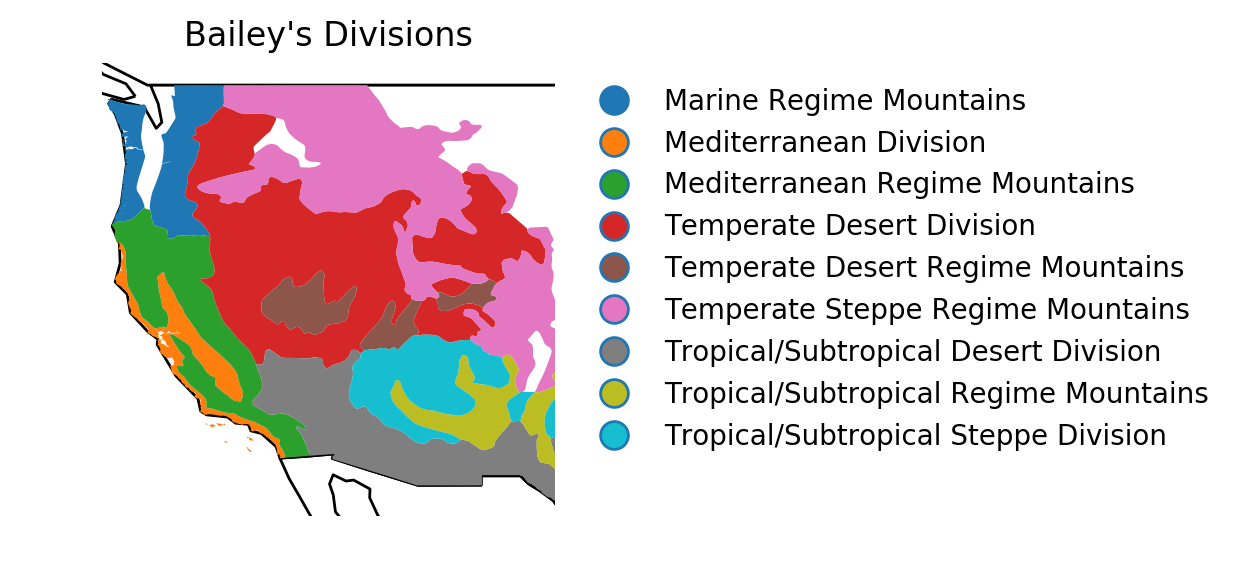

In [6]:
# Load US ecoregions and plot the united states land mass together
eco_dir = os.path.join("..", "Data", "LandCover", "eco-us-shp")
eco_shp = geopandas.read_file(eco_dir)
eco_shp = eco_shp.to_crs({'init': '+init=epsg:4326'})

# For political borders (plotting)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.to_crs({'init': '+init=epsg:4326'})

# Western US divisions to be included in this analysis 
desired_divisions = ["Temperate Steppe Regime Mountains", 
                     "Marine Regime Mountains", 
                     #'Marine Division', # No burn area! So will exclude
                     "Mediterranean Regime Mountains", # includes southern coastal Alaska sections
                     "Mediterranean Division",
                     'Temperate Desert Division',
                     "Tropical/Subtropical Steppe Division",
                     'Tropical/Subtropical Desert Division',
                     'Tropical/Subtropical Regime Mountains',
                     'Temperate Desert Regime Mountains',
                    ]

# Make a mask of the desired divisions
division_mask = eco_shp.DIVISION.isin(desired_divisions)
eco_shp_subset = eco_shp.loc[np.array(division_mask),:].copy()

# Join by common division, first subset to AREA and division only, make copy
section_rows = eco_shp_subset[['DIVISION', 'AREA', 'geometry']].copy()
geo_divisions = section_rows.dissolve(by='DIVISION', aggfunc='sum')

# Make row names a column (attribute)
geo_divisions['division'] = geo_divisions.index

# Show the selected divisions 
f, ax = plt.subplots(1, figsize=(3, 3), dpi=200)
base = world.plot(ax=ax, color="white", edgecolor="black")
ax1 = geo_divisions.plot(ax=base, column='division', legend=True)
ax.set_xlim(left=-125, right=-105)
ax.set_ylim(bottom=30, top=50)
ax.axis('off')
plt.title("Bailey's Divisions")

# handle the legend
leg = ax1.get_legend()
leg.set_bbox_to_anchor((1, 1, 1.5, 0.0))
leg.set_frame_on(False)
plt.show()

### Get the desired burn area data for the chosen divisions

In [7]:
# Read in burn area, in acres
fire_df = pd.read_csv(fire_file)

# subset by the desired divisions
division_mask = fire_df.columns.isin(desired_divisions)
print("--------------------------------")
print("Divisions used in this analysis:")
print("--------------------------------")

fire_df_subset = fire_df.loc[:,np.array(division_mask)].copy()

# MTBS data start Jan 1984, are monthly, and end in 2017. Make
# a time array date_range that matches this. 
time_mtbs = pd.date_range("1984-01-01", periods=len(fire_df), freq="M")

# Make the monthly time series the row index for the division fire data 
fire_df_subset.index = time_mtbs.copy()

fire_df = fire_df_subset.copy()
divisions = np.array(fire_df.columns)
del(fire_df_subset)
print(divisions)

--------------------------------
Divisions used in this analysis:
--------------------------------
['Marine Regime Mountains' 'Temperate Desert Division'
 'Temperate Steppe Regime Mountains'
 'Tropical/Subtropical Desert Division'
 'Tropical/Subtropical Steppe Division'
 'Tropical/Subtropical Regime Mountains' 'Mediterranean Regime Mountains'
 'Mediterranean Division' 'Temperate Desert Regime Mountains']


### Show a timeseries of division burn area

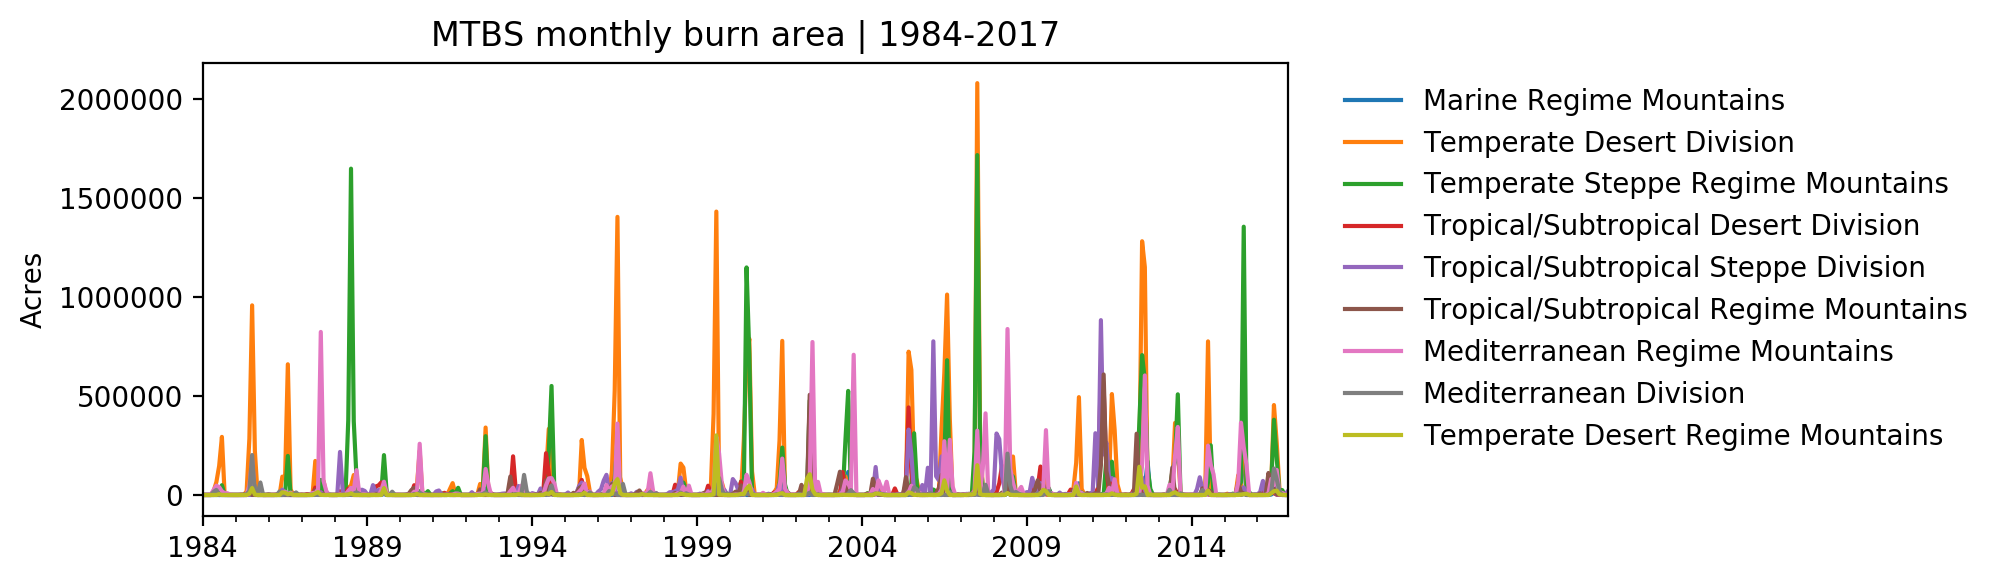

In [8]:
# Show the disolved divisions 
f, ax = plt.subplots(1, figsize=(7, 3), dpi=200)
#plt.plot(time_mtbs, BA)
ax1 = fire_df.plot(ax=ax)
plt.title("MTBS monthly burn area | 1984-2017")
plt.ylabel("Acres")

# handle the legend
leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.15, 1, 1.5, 0.0))
leg.set_frame_on(False)

plt.show()

### Bring in the western_US region to bring along for analysis
- This will allow large scale patterns to be observed
- Provide sanity checks on units
- Allow large area sigma in variables to be computed.
- Calculate burn area in region as sum of each ecoregion burn areas for each month. 

In [9]:
divisions = np.append(divisions, "western_US")
divisions

array(['Marine Regime Mountains', 'Temperate Desert Division',
       'Temperate Steppe Regime Mountains',
       'Tropical/Subtropical Desert Division',
       'Tropical/Subtropical Steppe Division',
       'Tropical/Subtropical Regime Mountains',
       'Mediterranean Regime Mountains', 'Mediterranean Division',
       'Temperate Desert Regime Mountains', 'western_US'], dtype=object)

In [10]:
western_US_burn_area = fire_df.sum(axis=1).copy()
fire_df["western_US"] = western_US_burn_area

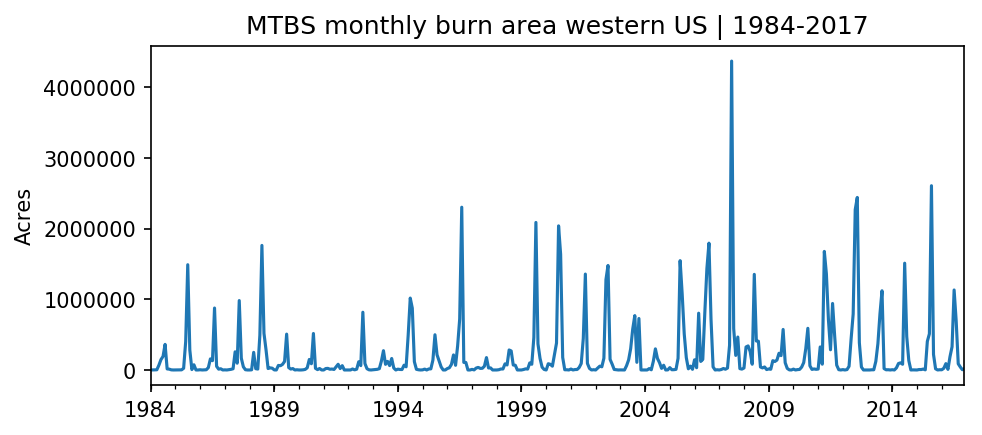

In [11]:
f, ax = plt.subplots(1, figsize=(7, 3), dpi=150)
ax1 = western_US_burn_area.plot(ax=ax)
plt.title("MTBS monthly burn area western US | 1984-2017")
plt.ylabel("Acres")
plt.show()

# Get Bailey's region corrosponding meteorology grids
- We make the assumption that the burn area in the baily's regions mapped above is driven my meteorology over the same spatial region. ERA-interim met (for training) and CMIP5 (for future projections) have been gridded to a common grid and I have figured out what grid boxes overlap what Bailey's divisions. 
- The following code gets masks for each bailey's division within the desired_divisions array. This allows us to subset the gridded meteorology for only the grid boxes that overlap the spatial area of interest. The spatial overlaps and mask creation was done with Python/create_ecoregion_overlap_masks.ipynb

In [12]:
# I need to know what met grid cells to keep with these divisions. Find which ones overlap. 
grid_division_masks_file = os.path.join("..", "Data", "LandCover", "bailys_division_masks_common_grid.nc")
nc = Dataset(grid_division_masks_file, 'r')

grid_lat = nc.variables['lat'][:].data
grid_lon = nc.variables['lon'][:].data

# Use any division grid's shape to set an empty array 
#division_mask = np.zeros(shape=nc.variables[divisions[0]][:].data.shape)

#for division in desired_divisions :
    
#    division_key = division.replace("/", " ")
#    # Where variables are greater than 0, that means that grid box
#    # overlaps the division. That means anywhere where
#    # division_mask > 0 is a grid box we want. 
#    division_mask += nc.variables[division_key][:].data
    
## setup a lat long mask, because we do not want grid boxes for the high latitude
## 'Marine Regime Mountains'
#lat_mask = grid_lat > 50. 
#division_mask[lat_mask,:] = 0

Baily ecoregion map examples

Function for getting era_nc_vals. Will be moved out of notebook when development is complete

In [13]:
def get_era_nc_variable(var, spatial_mask, spatialMean=False, startYear=1983):
    """
    # TODO: Move to utils
    This function will be for loading a particular nc file, which will be spatially subset.
    The data loaded are from the merged_t_COMMON_GRID directory. These data have been
    regridded from thier native resolution using cdo remapbil. 
    
    TODO: Add "endyear" as an argument in addition to "startyear" as new MTBS fire data is 
    TODO: going to require going further back in time to train the model. 
    
    Parameters
    ----------
        var : str, The variable (and file name) of the ECMWF era-interim data to be 
              loaded. 
        spatial_mask : numpy array, where equal to 0 are locations to keep data for and 
                       where equal to 1 (True) are grid points to mask (ignore data). 
        spatialMean : Boolean, if False (default) a spatial mean of the era-interim data
                      is not taken and the data are returned on a t,lon,lat grid. 
                  
    Return
    ------
        valsCut : The chosen "var" as a ndarray(t, lat, lon) or if spatialMean = True
                  ndarray(t). 
        t_monCut : pd.date_range describing the t axis of valsCut. 
        lonCut : longitude ndarray
        latCut : latitude ndarray
    
    """
    
    # Create link to the monthly file
    dataDir = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
    f = var + "_1983-2017.nc" 
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! 
    if(not os.path.isfile(loadFile)):
        raise ValueError(f + " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Create a new array, where each time slice will be a masked version 
    # of the data loaded from the nc file 
    vals_masked = np.ma.empty(shape=vals.shape)
    
    # Pandas handling of time so all models have the exact same origin and such. 
    t = nc.variables["time"]
    if(len(t) == 420):
        # Convert to pandas time array, on the assumption t[0]=startYear-01-01 the data
        # being monthly. Defualt files are 1983-2017.  
        t_mon = pd.date_range(str(startYear)+"-01-01", periods=len(t), freq="M")
    else:
        # there should always be 420 months in these data (35 years of data times 12)
        raise ValueError('Error in number of months for file: '+ f + " 420 expected.")
        
    # Now subset the data based on the passed spatial_mask
    for i in range(len(t)) : 
        vals_masked[i,:,:] = np.ma.masked_array(vals[i,:,:], mask=spatial_mask, copy=True)
    
    # take a spatial mean? 
    if spatialMean:
        # Masked entries are ignored
        vals_masked = np.ma.mean(vals_masked, axis=(1,2))
    
    return vals_masked, t_mon, lon, lat

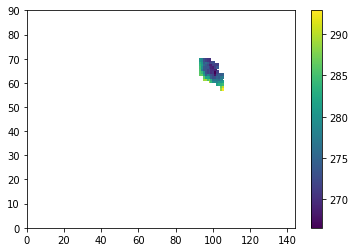

In [14]:
# Demonstrate that the masked array masks data outside of area of interst
t2m, t, lon, lat = get_era_nc_variable('t2m', nc.variables["western_US"][:]==0)
plt.pcolor(t2m[0,:,:])
plt.colorbar()
plt.show()

### Load desired ERA-Interim reanalysis
- Load each variable, take the spatial mean for the spatial_masks shown above and place in a dataframe where each row is a month and each column is a variable, each cell is a monthly mean value for the area. 

In [15]:
def get_division_era_variables(predictors, spatial_mask) : 
    """
    This script employs get_era_nc_variable() and loads the desired predictors 
    for a given ecoregion (division). The spatial mask needs to be passed. The
    spatial me of the data for a given division is taken when using this method
    because it returns a dataframe where the columns are the predictors and the 
    rows are the spatially average monthly-mean values. 
    
    Parameters
    ----------
        predictors : list, the era-interim variables to load. 
        spatial_mask : numpy.ndarray containing True and False values only. Values
                       are true for grid boxes not desired (to be used as masked) 
                       and values are False for the area with data to be averaged
                       spatially. 
    
    return
    ------
        A pd.DataFrame where the columns are the predictors and the 
        rows are the spatially average monthly-mean values. 
        
    """

    predictorDict = {}

    for var in predictors :

        predictorDict[var], t, lon, lat = get_era_nc_variable(var, spatial_mask, spatialMean=True)

    # Features used to estimate the target function    
    X_monthly = pd.DataFrame(predictorDict, index=t)
    
    return X_monthly 

In [16]:
predictors

['t2m', 'tp', 'si10', 'RH', 'slhf', 'VPD', 'mrlsl.integrated', 'e']

In [17]:
# Dictionary to store monthly values for predictors (era data)
X_monthly_dict = {}

for div in divisions : 
    
    # Remove forbiden charactors 
    division_key = div.replace("/", " ")
    #print(division_key)
    # NOTE: The division masks are stored such that 1 means in division, 0 means not.
    # NOTE: np.ma masking requires a true or 1 for values to mask, i.e. ignore, so 
    # NOTE: the data from the nc file for divisions is flipped when getting division 
    # NOTE: data 
    print(division_key)
    div_mask = nc.variables[division_key][:].data == 0
    X_monthly_dict[div] = get_division_era_variables(predictors, div_mask)
    #print(np.sum(X_monthly_dict[div].tp))
    
nc.close()

Marine Regime Mountains
Temperate Desert Division
Temperate Steppe Regime Mountains
Tropical Subtropical Desert Division
Tropical Subtropical Steppe Division
Tropical Subtropical Regime Mountains
Mediterranean Regime Mountains
Mediterranean Division
Temperate Desert Regime Mountains
western_US


### Change units of some ERA-Interim data to match CMIP5 output
Extensive notes can be found on these conversions in the file Python/make_era_and_CMIP5_units_identical.ipynb


#### Convert units on fields that need it 

In [18]:
print(predictors)

['t2m', 'tp', 'si10', 'RH', 'slhf', 'VPD', 'mrlsl.integrated', 'e']


In [19]:
for div in divisions : 
    
    # Get a regions met values to change units for 
    X_monthly = X_monthly_dict[div]
    
    tp = utils.m_to_mass_flux( np.array(X_monthly["tp"].copy()) )
    e = utils.e_to_mass_flux( np.array(X_monthly["e"].copy()) ) 
    slhf = utils.J_flux_to_W_flux( np.array(X_monthly["slhf"].copy()) )
    
    # Replace columns with updated versions
    X_monthly.loc[:, "tp"] = tp
    X_monthly.loc[:, "e"] = e 
    X_monthly.loc[:, "slhf"] = slhf
    
    # Finally, make the names of the era-interim variables match the names
    # in CMIP5 output. After this step, the units and names should match. 
    # t2m tp si10 RH slhf VPD mrso e
    X_monthly.rename(columns={"t2m":"tas","tp":"pr","si10":"sfcWind","RH":"hurs", 
                              "slhf":"hfls", "VPD":"VPD", 
                              "mrlsl.integrated":"mrlsl.integrated", "e":"evspsbl"}, 
                     inplace=True)
    
    # Place back in dictionary 
    X_monthly_dict[div] = X_monthly
    #print(X_monthly.columns)

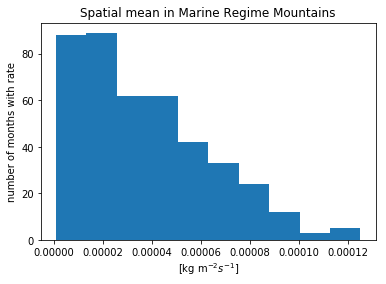

In [20]:
#plt.figure()
#plt.plot(X_monthly_dict['Marine Regime Mountains'].pr, tp_mass_flux)
#plt.xlabel("pr [m]")
#plt.ylabel("pr [kg m$^{-2}s^{-1}$]")
#plt.suptitle("ERA-Interim total precipitation (tp) meters to mass flux ratio")
#plt.title("(Should be linear)")
#plt.show()

plt.figure()
plt.hist(X_monthly_dict['Marine Regime Mountains'].pr)
plt.xlabel("[kg m$^{-2}s^{-1}$]")
plt.title("Spatial mean in Marine Regime Mountains")
plt.ylabel("number of months with rate")
plt.show()

In [21]:
divisions

array(['Marine Regime Mountains', 'Temperate Desert Division',
       'Temperate Steppe Regime Mountains',
       'Tropical/Subtropical Desert Division',
       'Tropical/Subtropical Steppe Division',
       'Tropical/Subtropical Regime Mountains',
       'Mediterranean Regime Mountains', 'Mediterranean Division',
       'Temperate Desert Regime Mountains', 'western_US'], dtype=object)

### Setup forecasting summer burn area using seasonal (varying t-lag) predictors and calculating summer burn area

#### Seasons to aggregate features
- summer (6,7,8)
- spring (3,4,5)
- winter (11,12,1,2) 

TODO: 
- Other previous years seasons? 

In [22]:
def make_monthly_seasonal(X_monthly, time_mtbs, inspect=False) :
    """
    Makes monthly met predictors seasonal by taking monthly predictors (features) 
    to means of seasons, winter=[11,12,1,2], spring=[3,4,5], summer=[6,7,8]. For 
    winter predictor, the months 11 and 12 will come from the previous year, so 
    when making predictors for a row (year) 2013, the months to be averaged are
    Nov 2012, Dec 2012, Jan 2013, Jan 2014. This is all meant to forecast burn area
    occurring in the months 6,7,8 (summer). 
    NOTE: When using this to convert CMIP5 monthly predictors to seasonal, because 
    NOTE: the time_mtbs argument will be cmip time, the first years (1984) _winter
    NOTE: features will be an average of Jan 1984 and Feb 1984, since there is no 
    NOTE: data for the previous year. All other year winter predictors are normal.
    
    Parameters
    ----------
        X_monthly : pd.DataFrame object with shape [months x features] where the index
                    is a datetimes.DatetimeIndex
        time_mtbs : datetimes.DatetimeIndex that matches either monthly burn area series
                    (for era-interim data) or the X_montly.index (for cmip data).
        inspect : When True, the masked time array used for each years seasonal predictors
                  will be printed. 
                  
    return
    ------
        pd.DataFrame : A dataframe [year x seasonal_feature] where each feature in the 
                       X_monthly pd.DataFrame has been expanded to var_winter, var_spring
                       var_summer. 
    """
        
    # Create summer burn area time series
    fire_years  = np.sort(np.unique(time_mtbs.year))
    nYears      = len(fire_years)

    # ERA data starts one year before the burn area data 
    era_time = X_monthly.index.copy()
    era_year = era_time.year
    era_month = pd.Series(era_time.month)

    # Create season masks (first month last month of season). Each season gets its own 
    # column in the features DataFrame.
    # NOTE: Make sure to not use months after wildfires in a given year, e.g. 
    # NOTE: December, unless set to the year before # Make sure to not use months 
    # NOTE: after wildfires in a given year, e.g. December, unless set to the year before 
    seasons = {"winter":[11,12,1,2], 
               "spring":[3,4,5], 
               "summer":[6,7,8]}

    # Make a dictionary to store predictors for each variable for each season 
    # of interest. 
    variables = np.array( X_monthly.columns.copy() )
    
    # To store predictor information 
    predictor_dict = {} 

    for pre in variables :
        for s in seasons.keys() :
            predictor_name = pre + "_" + s 
            predictor_dict[predictor_name] = np.zeros(nYears)

    # Loop through each year, assigning desired season predictor value 
    # within each year 
    for i in range(nYears):
        
        if inspect :
            print(fire_years[i])
        
        # Loop through seasons, within a year
        for s in seasons.keys():
            
            if inspect : 
                print(s)

            if s == 'winter' : 
                
                prev_year_mask = (fire_years[i]-1) == era_year
                m1 = era_month.isin([11,12])
                tChuchk1 = prev_year_mask & m1
                
                this_year_mask = fire_years[i] == era_year
                m2 = era_month.isin([1,2])
                tChuchk2 = this_year_mask & m2
                # Want an array than combines the True locations, "or" in other
                # words 
                tChunk = tChuchk1 | tChuchk2
                
                if inspect :
                    print(era_time[tChunk])
                
            else :
                
                # The non-winter predicors months fall into the same year as fire activity
                year_mask = fire_years[i] == era_year
                
                # Mask the months that fall into the current season of interest
                month_mask = era_month.isin(seasons[s])

                # combine to make a single mask
                tChunk = month_mask & year_mask 
                
                if inspect :
                    print(era_time[tChunk])

            # For each predictor variable, loop through taking relevant stat
            for pre in variables:
                k = pre + "_" + s
                predictor_dict[k][i] = np.mean(X_monthly.loc[era_time[tChunk], pre].copy())
    
    # Return a DataFrame of era data as desired seasonal features 
    return pd.DataFrame(predictor_dict, index=fire_years)

### Make monthly era data into seasonal means for each division 

In [23]:
X_seasonal_dict = {}
for div in divisions : 
    X_seasonal_dict[div] = make_monthly_seasonal(X_monthly=X_monthly_dict[div], time_mtbs=time_mtbs)
    
# these data need to be saved
with open(os.path.join(save_dir_base, "ERA_features_dict.obj"), 'wb') as fp :
    pickle.dump(X_seasonal_dict, fp)

### Make monthly burn area data into target season burn area totals 
https://stackoverflow.com/questions/38792122/how-to-group-and-count-rows-by-month-and-year-using-pandas

In [24]:
# Subset rows to burn_area_season, then 
df_= fire_df[fire_df.index.month.isin(burn_area_season)].copy()
# Aggregated by season is the target function, y, so start calling it y. 
y_seanonal_df = df_.groupby(df_.index.year).agg('sum').copy()
del(df_)

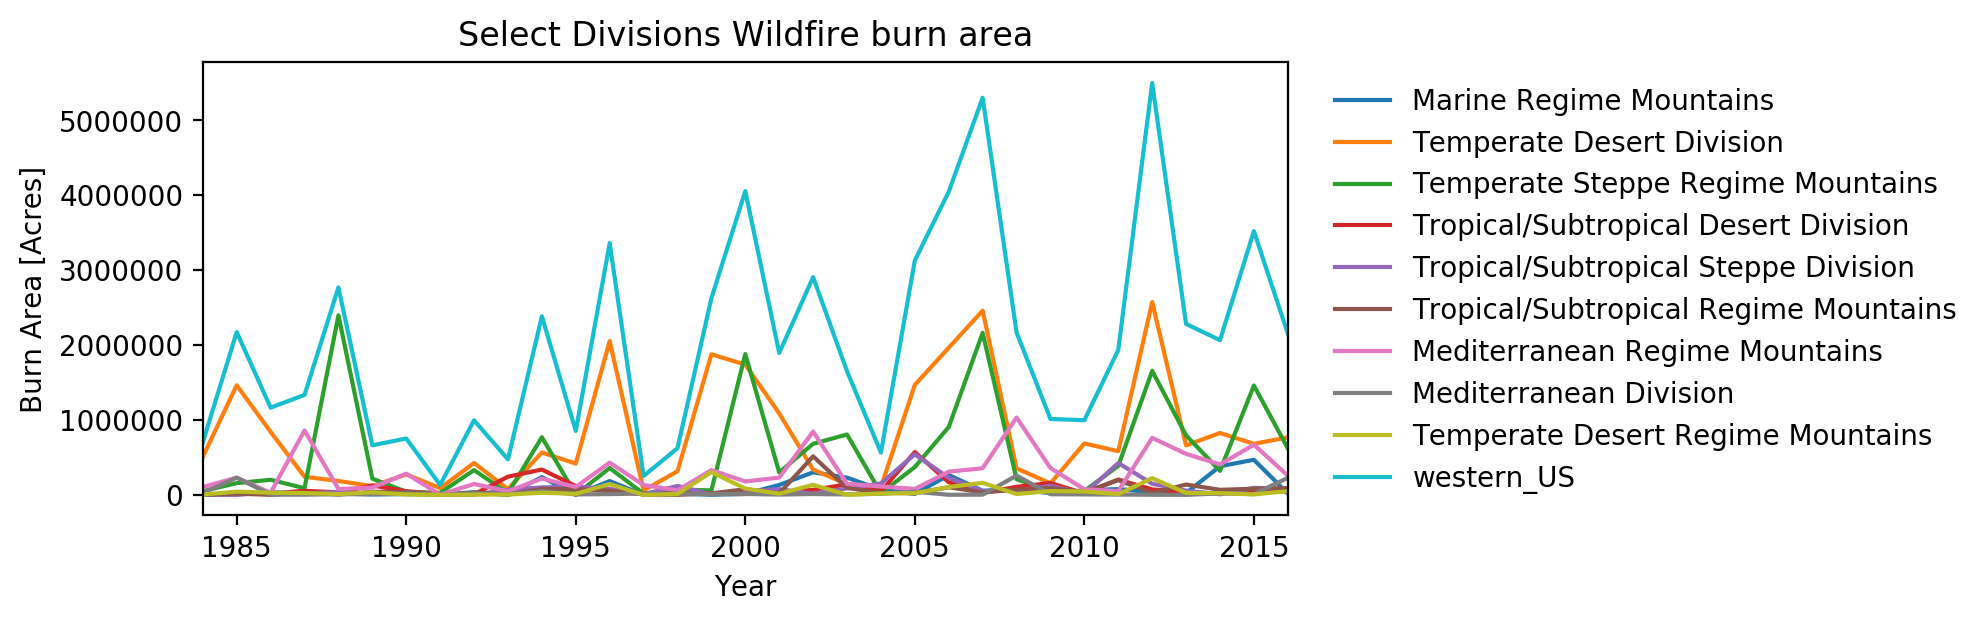

In [25]:
f, ax = plt.subplots(1, figsize=(7, 3), dpi=200)
y_seanonal_df.plot(ax=ax)
plt.title("Select Divisions Wildfire burn area")
plt.ylabel("Burn Area [Acres]")
plt.xlabel("Year")
plt.legend()

# handle the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.14, 1, 1.5, 0.0))
leg.set_frame_on(False)

plt.show()

## Standardize and detrend the predictors (features) for seasonal burn area variance analysis
- The mean and standard deviation of the features needs to be saved in order for bias correcting CMIP5 output later. 
- These data need to be detrended before regression. 
- Sets up forecasting year to year variability without interference on long term trends, a different analysis
- **NOTE:** Pandas.DataFrame.std() uses ddof=1 by default, while numpy uses ddof=0 by defualt. Make sure you are consistent otherwise the way data standard deviation is expressed will change throughout use. 

In [26]:
# Dictionary to store DataFrames of the standardized features
Z_dict = {}

feature_names = X_seasonal_dict[list(X_seasonal_dict.keys())[0]].columns

# Argument, detrend the data? Consequences down the pipeline as far as it goes. 
detrend = True

# Make DataFrames where the means and std of feature data can be saved 
# [division x feature]
X_mean_df = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                         columns = feature_names)
# [division x feature]
X_std_df = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                        columns = feature_names)
# [division x feature]
era_feature_slope = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                                 columns = feature_names)
era_feature_slope_pvalue = pd.DataFrame(np.nan, index = X_seasonal_dict.keys(),
                                        columns = feature_names)

for i in divisions : 
    
    # Get the features for a division
    X = X_seasonal_dict[i]
    x = X.index.values # for getting linear regression, units with years
    
    # Calculate and store in correct location, means and std
    # NOTE: detrending does not change the mean 
    X_mean_df.loc[i, X.mean().index] = X.mean().copy()
    
    if detrend :
        
        for feature in X.columns : 
            
            # Regression on the feature
            xi = X.loc[:, feature].values 
            lm = stats.linregress(x, xi)
            era_feature_slope.loc[i, feature] = lm.slope
            era_feature_slope_pvalue.loc[i, feature] = lm.pvalue
        
        # Create a temporary df to save desired features of
        # pd DataFrame, while they are converted to an array
        # for detrending using scipy.signal 
        df_temp = pd.DataFrame(np.nan, columns=X.columns.values, index=X.index.values)
             
        # Make a de-trended version of these data
        X_detrended     = signal.detrend(X.values, axis=0)
        X_detrended_std = np.std(X_detrended, axis=0)
        
        # Standardize the X feature data and store in Z_dict
        X_std_df.loc[i, X.columns.values] = X_detrended_std
        
        Z_detrended = ( X_detrended / X_detrended_std )
        #print(Z_detrended.std(axis=0))
        
        df_temp.iloc[:,:] = Z_detrended
        Z_dict[i] = df_temp
                
    else :
        
        # Standardize the X feature data and store in Z_dict
        X_std_df.loc[i, X.std().index] = X.std(ddof=0).copy()
        Z_dict[i] = ( (X-X.mean()) / X.std(ddof=0) ).copy()
    
# Save these mean and std values, they are needed for projections
X_mean_df.to_csv(os.path.join(save_dir_base, "feature_means.csv"))
X_std_df.to_csv(os.path.join(save_dir_base, "feature_std.csv"))

# Save the slopes and their pvalues, this could be handy later
era_feature_slope.to_csv(os.path.join(save_dir_base, "feature_slopes.csv"))
era_feature_slope_pvalue.to_csv(os.path.join(save_dir_base, "feature_slopes_pvalues.csv"))

In [27]:
X.loc[:, feature].dtype

dtype('float64')

### Implement a custom cross validation scheme that minimizes leave one out sample error
- Alpha varies how harsh the model is, the bigger alpha, the more predictors are eliminated. When alpha = 0 Lasso is the same as OLS regression. And with this many features, it will FOR SURE be overfit. 
- Below the slope of wildfire burn area, as well as slope alpha, are saved.
- The Lasso is fit to 1) all variables available at once, 2) atmos-centric variables only, 3) plant-centric variables only. The results for all three are saved, including the trained regressions themselves. 
- TODO: Evaluate and come up with some metric for stability. 


````Python 
for year_left_out in range(1984:2016) :
    Xs = X[!year_left_out, ]
    
    leave_one_out_model = LassoCV()

 Calculate mean error for this alpha
````

In [28]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoCV, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import warnings # For all kinds of converge issues

In [29]:
def plot_all_relationships(Y, X, ecoregion) : 
    """
    Scatterplot the burn area data against all features. One axis per
    feature, and each feature season is a different color.
    
    Parameters
    ----------
        Y : The variable we are trying to predict
        X : The matrix (dataframe) of features used to predict Y. Show
            scatter relationship. 
            
    """
    eco_write = ecoregion.replace(" ","_").replace("/"," ")
    scatter_fig = os.path.join(save_dir_base, eco_write + "_Z_vs_burn_area.png")
    
    n_features = X.shape[1]
    feature_names = X.columns
    
    fig = plt.figure(figsize=(10,15), dpi=200)
    
    panel = 0
    for feature in feature_names :
        panel += 1
        ax = plt.subplot(8, 3, panel)    
        x = X.loc[:, feature ]
        r = np.round(np.corrcoef(x, Y)[0][1], 4)
        
        plt.scatter(x, Y.values, label="r=%f" % r)
        plt.title(feature)
        plt.legend()
        plt.xlabel("")
        plt.gca().axes.get_yaxis().set_visible(False)
    
    fig.suptitle(ecoregion +" burn area vs feature", fontsize=14)
    plt.subplots_adjust(hspace=0.4)
    plt.savefig(fname=scatter_fig, format='png')
    plt.close()
    

def show_model_skill(y_orig, z, y, model, var_type, fname, div, transformation="log10") :
    """
    Predict historical values using optimal alphas.
    plots the following:
        1) model coeficients
        2) y vs. y_hat time series
        3) y vs. y_hat 1:1
        4) model residuals
        
        # TODO: Make into a class. 
        
    Parameters
    ----------
        y : the target values as an array
        Z : the features used to predict the target as a pd.DataFrame
        model : from LassoCV or similar, to be sumarized
        fname : image save location
    
    """
    
    years = np.array(z.index)
    
    # Make prediction
    y_hat = model.predict(z)
    
    # Setup figure 
    fig = plt.figure(dpi=200, figsize=(22, 12))
    
    fig.suptitle(div + " " + var_type  + " regression summary", fontsize=14)
    
    #########################################################
    # Show the target function that we are trying to predict 
    #########################################################
    plt.subplot(2, 4, 1)
    plt.plot(years, y_orig, "-o", label="MTBS")
    plt.axhline(y=0, linestyle="--", color="k")
    plt.legend()
    plt.title("Unaltered MTBS burn area")
    
    ##########################################
    # Plot distribution before log10 transformation
    ##########################################
    if transformation == 'log10' : 
        transformed = 10**y
        xlabel = "10^(detrended( log_{10}(y ))"
    else :
        transformed = y
        xlabel = "detrended y"
        
    plt.subplot(2, 4, 2)
    plt.hist( y )
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.title("Distribution of the detrended target")
    
    ########################################
    # Plot distribution 
    ########################################
    plt.subplot(2, 4, 3)
    plt.hist( y )
    if transformation == 'log10' : 
        plt.xlabel("detrended( log10(y) )")
    else :
        plt.xlabel("detrended y ")
        
    plt.ylabel("count")
    plt.title("Distribution of the detrended target")
    
    ##########################################
    # Show the coeficients for the model_best
    ##########################################
    plt.subplot(2, 4, 4)

    plt.bar(z.columns.values, model.coef_)
    plt.axhline(y=0, c="k", linestyle="--")
    plt.xticks(rotation='vertical')
    plt.xlabel("Feature")
    plt.ylabel("Coefficients")
    plt.title("Feature coefs for least square error model, $\\alpha$=" + str(np.round(model.alpha_, 4)))
    #plt.xticks(rotation=45)

    ########################################
    # Plot obs and modeled values for both
    ########################################
    r2 = np.round(metrics.r2_score(y_true=y, y_pred=y_hat),4)
    plt.subplot(2, 4, 5)
    plt.plot(years, y, '-o', label="transformed observation")
    plt.plot(years, y_hat, '--o', label="model")
    plt.ylabel("log$_{10}$(acres burned)")
    plt.legend()
    plt.title("Time series & mode | R$^{2}$=" + str(r2))

    ########################################
    # Show the MSE path across alphas 
    ########################################
    plt.subplot(2, 4, 6)
    plt.plot(model.alphas_, np.mean(model.mse_path_, axis=1), label="mean MSE across folds")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("Mean MSE of folds")
    plt.axvline(model.alpha_, color="k", linestyle="--", label="selected $\alpha$")
    plt.title("RMS path across " + r"$\alpha$")
    
    ########################################
    # Plot observations vs. modeled values
    ########################################
    x1 = np.linspace( np.min([y, y_hat]), np.max([y, y_hat]) )
    r = np.round(np.corrcoef(y, y_hat)[0][1], 3)

    plt.subplot(2, 4, 7)
    plt.plot(x1, x1, color="k", linestyle=":", label="1:1")
    plt.scatter(y, y_hat, c=years)
    plt.xlabel("Observation")
    plt.ylabel("Predicted")
    plt.title("Observation vs. predicted values | r="+str(r))
    plt.colorbar()

    ########################################
    # Plot residuals 
    ########################################
    zero = np.zeros(len(years))
    
    plt.subplot(2, 4, 8)
    plt.scatter(years, y-y_hat)#, c=years)
    plt.plot(years, zero, color="k", linestyle=":")
    if transformation == 'log10' : 
        plt.ylabel("log$_{10}$(acres burned)")
    else :
        plt.ylabel("acres burned")
        
    plt.title("Model residuals")
    
    # overall styling
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig(fname=fname, format='png')
    plt.close()
    
def separate_predictors(atmos_vars, plant_vars, x) : 
    """
    Separates predictor DataFame (x) into plant and atmos centric predictos 
    based on the lists atmos_vars and plant_vars. 
    """
    # Clean up the symbols for precise str.contains statements 
    atmos_vars_str = str(atmos_vars).replace("'","").replace(" ","").replace(",","|").replace("[","").replace("]","|").replace("pr","pr_")[:-1]
    plant_vars_str = str(plant_vars).replace("'","").replace(" ","").replace(",","|").replace("[","").replace("]","|").replace("pr","pr_")[:-1]
    # make masks
    atmos_mask = np.array(pd.Series(x.columns).str.contains(atmos_vars_str))
    plant_mask = np.array(pd.Series(x.columns).str.contains(plant_vars_str))
    
    x_atmos = x.iloc[:, atmos_mask].copy()
    x_plant = x.iloc[:, plant_mask].copy()

    return x_atmos, x_plant


def get_OLS_score(Z, y) : 
    """
    Gets r-squared score for a target using a matrix of features. 
    """
    linear_model = LinearRegression()
    _ = linear_model.fit(Z, y)
    score = linear_model.score(Z, y)
    return score

### Setup the DataFrames that will save the key results
- to save for plotting and analysis purposes elsewhere. 

In [30]:
# Create a dataframe for a summary of results from multiple linear
# models 
results_df = geo_divisions.copy()

# Blank array for setting column values to nothing before valueas
# assigned
blank= np.full(results_df.shape[0], np.nan)

results_df['OLS_r2']        = blank.copy() # variance explained by OLS - no regularization

results_df['lasso_r2']      = blank.copy() # variances explained by lasso regression, all variables
results_df['lasso_alpha']   = blank.copy() # alpha selected by cross validation

results_df['atmos_r2']      = blank.copy() # variance explained by atmos only R-squared
results_df['atmos_alpha']   = blank.copy() # Optimal alpha value for atmos

results_df['plant_r2']      = blank.copy() # variance explained by plant only R-squared 
results_df['plant_alpha']   = blank.copy() # Optimal alpha value for plants 

# And finally, create dataframes for the coefs from each regression 
lasso_all_coefs   = geo_divisions.copy()
lasso_atmos_coefs = geo_divisions.copy()
lasso_plant_coefs = geo_divisions.copy()

# Now this dataframe will also have information on Lasso predictor coef values
# columns for each predictor value will be placed in the loop below. 
predictors = X_seasonal_dict[list(X_seasonal_dict.keys())[0]].columns.values
for p in predictors : 
    
    # All predictors go into this dataframe
    lasso_all_coefs[p] = np.zeros(results_df.shape[0])
    
    # Only plant predictors go into this one
    if pd.Series(p.split("_")[0]).isin(plant_vars)[0] :
        lasso_plant_coefs[p] = np.zeros(results_df.shape[0])
    
    # And only atmos ones here
    if pd.Series(p.split("_")[0]).isin(atmos_vars)[0] :
        lasso_atmos_coefs[p] = np.zeros(results_df.shape[0])
        
# Create a dataframe to save information about the trends in burn area
df_slopes = pd.DataFrame(np.nan, index=divisions, columns=["slope", "pvalue"])

## Lasso Regression Fitting
- TODO: create outside loop for external cross validation. 
    - For what is done now, repeated for EVERY year left out. Keep track of
        - Selected alpha
        - square error on left out year
        - the non-zero coeficients. This will give a confidense on how often a given variable is selected, if there is massive changes from year to year, that should be reported and we can better understand how stable/unstable the solutions are. 
        

In [31]:
y[y]

NameError: name 'y' is not defined

In [ ]:
print(Z.shape)

In [103]:
class relaxo() :
    """
    Custom implementation of the double lasso. 
    
    Parameters
    ----------
        y : pd.Series, these are the data to predict.  
        X : These are the features used to predict y. The goal
            of this class is to eliminate the not so useful features
            in X, to make better predictions on y. 
        transformation : transformation of y. 
    """
    
    def __init__(self, X, y, transformation = "none") : 
        self.X = X
        self.y = y
        self.transformation = transformation
        
    def transform_target(self) :
        """
        Make nesssisary changes to the target y.
        - make specified transformation
        - remove linear trend
        - store as self.y_target, this is the y value used for fitting. 
        """
        y_original = self.y 
        if transformation == "log10" :
            # We replace 0 values with 1 so that 
            # taking the base 10 logarithm is valid
            y_original.loc[y_original==0] = 1.
            y_log = np.log10(y_original.values)
            y_log_detrend = signal.detrend(y_log)
            y_target = y_log_detrend.copy() 
        elif transformation == "none" : 
            # Do not alter the burn area, aside from taking the
            # autoregression (slope) away.
            y_detrend = signal.detrend(y_original)
            y_target = y_detrend.copy()
        else :
            raise ValueError("tansformation not reconize. Choose valid transformation.")
        
        # This is the     
        self.y_target = y_target
    
    def subset_features(self, max_iter = 100000, tol = 0.001, normalize=False) : 
        """
        First layer of lasso regression. We keep track of what features
        are selected to have non-zero coefs where the lassoCV is fit to 
        each year left out of the data, a bit like external cross validation. 
        """
        
        X = self.X
        y = self.y_target
        
        # save the LassoCV alpha value for each year left out
        outer_alpha = [] 
        
        years = X.index.values
        n_years = X.shape[0]
        n_features = X.shape[1]
        
        # Keeps track of each time a coef had a non-zero coef
        coef_counter = pd.DataFrame(0, index=1, columns=X.columns)
        
        # for a given year left out of outside loop, what was the coef,
        # consisency will be interesting. 
        coef_values = pd.DataFrame(0, index=years, columns=X.columns)
        
        for year in years : 
            
            rows_to_keep = years!=year
            X_year_out = np.array(Z.iloc[rows_to_keep, :])
            y_year_out = np.array(y[rows_to_keep])
            
            m = LassoCV(cv=LeaveOneOut(), normalize=normalize, tol=tol, max_iter=max_iter)
            m.fit(X_year_out, y_year_out)
            
            # Store fit information
            out_alpha.append(m.alpha_)
            coef_values.loc[year, :] = m.coef_
            coef_counter.loc[year, (np.abs(m.coef_) > 0) ] += 1
        
        self.coef_counter = coef_counter
        self.coef_values = coef_values
        return ceof_values, coef_counter 
    
    def second_lasso(self, max_iter = 100000, tol = 0.001, normalize=False) : 
        """
        Implements LassoCV() with leave-one-out to 
        find the final model. This uses the subset 
        of X values that were determined to be useful
        with the external nest
            Parameters
            ----------
                max_iter : see LassoCV()
                tol : see LassoCV()
                normalize: see LassoCV(), set to false because our data are centered
                           by design. 
        """
        X_second = np.array(self.X_subset_features)
        y = np.array(self.y_target )
        lasso_model = LassoCV(cv=LeaveOneOut(), normalize=normalize, tol=tol, max_iter=max_iter)
        lasso_model.fit(X_second, y)
        
        # TODO: translate these coefs back to original data locaitons (columns)
        return lasso_model
    
    

In [73]:
print(divisions)
print(len(divisions))

['Marine Regime Mountains' 'Temperate Desert Division'
 'Temperate Steppe Regime Mountains'
 'Tropical/Subtropical Desert Division'
 'Tropical/Subtropical Steppe Division'
 'Tropical/Subtropical Regime Mountains' 'Mediterranean Regime Mountains'
 'Mediterranean Division' 'Temperate Desert Regime Mountains' 'western_US']
10


In [81]:
#warnings.filterwarnings('ignore')

# Parameters # defaults 
max_iter = 100000 # 1000
tol      = 0.001 #0.0001

# The type of transformation to take on the burn area data 
transformation = "none"

# Create storage dictionaries 
div_lasso_list = {}    # A dictionary to store the trained regressions associated with divisions 
div_lasso_targets = {} # save what was fitted
div_ylog10 = {}        # Save the log10 values before detrending 
div_BA_original = {}   # Save the orignal burn area values

years = y_seanonal_df.index.values

#divGo = [divisions[7]]

for div in divisions : #divGo : # 
    
    div_lasso_list[div] = {}
    
    print("Training " + div)
    ##########################################################################
    # Handle transformations of the target (burn area)
    ##########################################################################
    y_original = y_seanonal_df.loc[:, div].copy()
    
    if transformation == "log10" :
        # We replace 0 values with 1 so that taking the base 10 logarithm is valid
        y_original.loc[y_original==0] = 1.
        y_log = np.log10(y_original.values)
        y_log_detrend = signal.detrend(y_log)
        y = y_log_detrend.copy()
        
        div_ylog10[div] = y_log
        
    elif transformation == "none" : 
        # Do not alter the burn area, aside from taking the
        # autoregression (slope) away.
        y_detrend = signal.detrend(y_original)
        y = y_detrend.copy()
        
    else :
        raise ValueError("tansformation not reconize. Choose valid transformation.")
        
    # Get the detrended normalized features for prediction
    Z = Z_dict[div]    
        
    # Plot the relationship between the burn area in this region and 
    # all standardized features. 
    plot_all_relationships(Y=y_original, X=Z, ecoregion=div)
    
    # Save important components of the transformations above
    div_lasso_targets[div] = y
    div_BA_original[div] = y_original
        
    # Save the stats on the burn area trends
    linear_model = stats.linregress(years, y_original.values)
    df_slopes.loc[div, "slope"] = linear_model.slope
    df_slopes.loc[div, "pvalue"] = linear_model.pvalue
        
    # Save OLS score
    results_df.loc[div, 'OLS_r2'] = get_OLS_score(Z.values, y) 
    
    # Fit a Lasso model using LOO
    # - We set normalize= False since our predictors are already normalized
    lasso_model = LassoCV(cv=LeaveOneOut(), normalize=False, tol=tol, max_iter=max_iter)
    lasso_model.fit(Z.values, y)
    
    # Save desired output 
    results_df.loc[div, 'lasso_alpha']= lasso_model.alpha_
    results_df.loc[div, 'lasso_r2'] = lasso_model.score(Z, y)
    lasso_all_coefs.loc[div, Z.columns] = lasso_model.coef_
        
    # Save a plot of these results. 
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + ".png")
    show_model_skill(y_original, Z, y, lasso_model, "all vars", fname, div, transformation)
    
    # Save the trained classifier
    div_lasso_list[div]["lasso_all"] = lasso_model
    
    # Repeat, but now only use either atmos or plant centric predicts, one at a time
    # save results. 
    Z_atmos, Z_plant = separate_predictors(atmos_vars, plant_vars, Z)
    
    #################################################################################
    # Fit a Lasso model using atmos only
    lasso_atmos = LassoCV(cv=LeaveOneOut(), normalize=False, tol=tol, max_iter=max_iter)
    lasso_atmos.fit(Z_atmos, y)    
    results_df.loc[div, 'atmos_r2'] = lasso_atmos.score(Z_atmos.values, y) 
    results_df.loc[div, 'atmos_alpha'] = lasso_atmos.alpha_
    lasso_atmos_coefs.loc[div, Z_atmos.columns] = lasso_atmos.coef_
    # Save a plot that shows summary of results
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_atmos.png")
    show_model_skill(y_original, Z_atmos, y, lasso_atmos, "atmos-centric", fname, div, transformation)
    div_lasso_list[div]["lasso_atmos"] = lasso_atmos
    
    #################################################################################
    # Fit a Lasso model using plant only 
    lasso_plant = LassoCV(cv=LeaveOneOut(), normalize=False, tol=tol, max_iter=max_iter)
    lasso_plant.fit(Z_plant.values, y)    
    results_df.loc[div, 'plant_r2'] = lasso_plant.score(Z_plant, y)     
    results_df.loc[div, 'plant_alpha'] = lasso_plant.alpha_
    lasso_plant_coefs.loc[div, Z_plant.columns] = lasso_plant.coef_

    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_plant.png")
    show_model_skill(y_original, Z_plant, y, lasso_plant, "plant-centric", fname, div, transformation)
    div_lasso_list[div]["lasso_plant"] = lasso_plant
    
    print("Done training " + div)
        
#warnings.filterwarnings('default')

print("Done training all divisions!")

Training Marine Regime Mountains
Done training Marine Regime Mountains
Training Temperate Desert Division
Done training Temperate Desert Division
Training Temperate Steppe Regime Mountains
Done training Temperate Steppe Regime Mountains
Training Tropical/Subtropical Desert Division


/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

Done training Tropical/Subtropical Desert Division
Training Tropical/Subtropical Steppe Division


/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

Done training Tropical/Subtropical Steppe Division
Training Tropical/Subtropical Regime Mountains


/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

Done training Tropical/Subtropical Regime Mountains
Training Mediterranean Regime Mountains


/Users/sbrey/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Done training Mediterranean Regime Mountains
Training Mediterranean Division
Done training Mediterranean Division
Training Temperate Desert Regime Mountains


/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Done training Temperate Desert Regime Mountains
Training western_US
Done training western_US
Done training all divisions!


In [82]:
# Save the trained classifiers 
# TODO: Best practice would be to save the features and target these
# TODO: were trained on. 
with open(os.path.join(save_dir_base, "trained_regressions.obj"), 'wb') as fp :
    pickle.dump(div_lasso_list, fp)
    
if transformation == 'log10' : 
    with open(os.path.join(save_dir_base, "div_log10_burn_area_dict.obj"), 'wb') as fp :
        pickle.dump(div_ylog10, fp)
    
with open(os.path.join(save_dir_base, "div_original_burn_area_dict.obj"), 'wb') as fp :
    pickle.dump(div_BA_original, fp)

In [68]:
results_df[["atmos_r2","plant_r2"]]

atmos_r2  plant_r2
DIVISION                                                     
Marine Regime Mountains                3.575793e-01  0.299282
Mediterranean Division                 9.760661e-02  0.282432
Mediterranean Regime Mountains         5.609035e-01  0.335427
Temperate Desert Division              2.123768e-01  0.444536
Temperate Desert Regime Mountains      0.000000e+00  0.322594
Temperate Steppe Regime Mountains      6.011768e-01  0.468403
Tropical/Subtropical Desert Division   3.330669e-16  0.331421
Tropical/Subtropical Regime Mountains  2.095376e-01  0.225254
Tropical/Subtropical Steppe Division   1.461814e-01  0.264917
western_US                             2.872747e-01  0.496869

In [56]:
5.335975e-01

0.5335975

### TODO: 
- Table of coefs and mean trends from CMIP5 model would be very powerful hear, then, a final column as the number of acres increse that represents by 2050 and 2100.
- There is some .iloc trickery occuring below to account for for the fact that I do not have a geometry for western_US and even if I did it would not make sense to save in the same geodataframe since it would overwrite all the rest in plotting. 
    - Remove the .iloc tricky when needed. Be aware. 

In [70]:
# save the results_df
# TODO: Change the name of the save directory based on 
# TODO: the conditions of this experiment run by this notebook. 
results_df.iloc[:-1,:].to_file(filename=os.path.join(save_dir_base, 'results_geo_df'))
results_df_ = pd.DataFrame(results_df.iloc[:-1,1:].copy())
results_df_.to_csv(os.path.join(save_dir_base, 'results_df.csv'))

In [71]:
# Save the coef DataFrames as well. Only save coefs, so exclude first 3 columns
pd.DataFrame(lasso_all_coefs.iloc[:, 3:]).to_csv( os.path.join(save_dir_base, 'lasso_all_coefs.csv') )

# Create and save the plant coefs df
lasso_plant_coefs = pd.DataFrame(lasso_plant_coefs.iloc[:, 3:]).copy()
lasso_plant_coefs.to_csv( os.path.join(save_dir_base, 'lasso_plant_coefs.csv') )

# Create and save the atmos coefs df 
lasso_atmos_coefs = pd.DataFrame(lasso_atmos_coefs.iloc[:, 3:]).copy()
lasso_atmos_coefs.to_csv( os.path.join(save_dir_base, 'lasso_atmos_coefs.csv') )

# Create and save a combined coefs from the plant- and atmos-centric regressions
# that were performed independently. 
lasso_combined_coefs = pd.concat([lasso_plant_coefs, lasso_atmos_coefs], axis=1, sort=False)
lasso_combined_coefs.to_csv( os.path.join(save_dir_base, 'lasso_combined_coefs.csv') )

# Save out trends in burn area 
df_slopes.to_csv( os.path.join(save_dir_base, 'burn_area_trends.csv') )

**NOTE:** Different divisions will need different variables, based on where coefs are greater than zero, so
different divisions will have different models and total models with availability. 

# Examine selected variables spread in CMIP5 data from RCP45 and RCP85
#### For a given division (ecoregion)
- What predictors are required based on non-zero coefs? 
- Get those predictors loaded into a DataFrame [month x variable]
    - Make sure this is the same size (same # of columns and column names) as X_monthly. That way coeficients from the lasso can be applied across columns. 
- Make into seasonal predictors, using make_monthly_seasonal(), exactly same method as for era-iterim data
- Repeat last two bullet-points for all available CMIP5 models

In [72]:
def get_cmip5_nc(var, rcp, model, spatial_mask, spatial_mean=False, inspect=False):
    """
    This function will be for loading a particular CMIP5 NetCDF file, which will be spatially subset 
    by this function. These CMIP5 model output to be loaded have been regridded to the "Common grid" 
    using $ cdo remapbil. Defualts to taking the spatial mean of all global data for the var argument. 
    Change area loaded using the minX, maxX, etc. arguments. 
    
    Parameters
    ----------
        var : str, The CMIP5 variable name to be loaded. File names match variable names. 
        rcp : str, "45" or "85", refers to representative concentration pathway. 
        model : The name of the model that created the var, to be loaded from. 
        spatial_mask : numpy array, where equal to 1 (True) are locations to mask, meaning
                       they will NOT be used in calculations, spatial means, etc. 
        spatial_mean : Boolean, if False (default) the data  will be returned on a 
                       [t, lon, lat] grid. 
    
    Return
    ------
        valsCut : array[month, lat, lon] for the chosen spatial extent or 
                  array[month] spatial mean for the chosen spatial extent. 
        t_mon : array of months as pd.date_range object. 
        lon : array of longitude values that were used aftering trimming the global data
        lat : array of latitude values that were used after trimming the global data
    
    """
        
    if var == 'mrso' :
        domain = 'Lmon'
    elif var == 'mrlsl.integrated' :
        domain = 'Lmon'
    else :
        domain = 'Amon'
        
    # Create link to the monthly file in this projects directory structure. 
    dataDir = os.path.join(".." ,"Data" ,"CMIP5" ,'r1i1p1_rcp_COMMON_GRID')
    f = var + "_" + domain + "_" + model + "_rcp" + rcp + "_r1i1p1_198301-210012.nc"
    
    if inspect :
        print(f)
        
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! Data logs indicate that not all requests exist
    if(not os.path.isfile(loadFile)):
        raise ValueError(f+ " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Create a new array, where each time slice will be a masked version 
    # of the data loaded from the nc file 
    vals_masked = np.ma.empty(shape=vals.shape)
    
    # Pandas handling of time so all models have the exact same origin and such. 
    # TODO: handle required changes to this section for when historical CMIP5 data
    # TODO: are also used. 
    t = nc.variables["time"]
    if(len(t) == 1416) :
        # Convert to pandas time array, on the assumption t[0]=2006-01 & t[-1]=2100-12
        t_mon = pd.date_range("1983-01-01", periods=len(t), freq="M")
    else:
        raise ValueError('Error in number of months for file: '+ f + " 1416 expected.")
        
    # Now subset the data based on the passed spatial_mask
    for i in range(len(t)) : 
        vals_masked[i,:,:] = np.ma.masked_array(vals[i,:,:], mask=spatial_mask, copy=True)
    
    # Now, take the mean value in this spatial domain. Note, the 
    # same is done to the era-interim data using the method:
    # get_era_nc_vals()
    if spatial_mean :
        
        # There is some extra stuff in here to make sure that
        # values of np.nan for soil moisture also get masked. 
        # i.e., in short, this masked all np.nan values too 
        # when time means of the division masked values are taken. 
        
        spatial_mask_3d = vals_masked.mask
        nan_mask = np.isnan(vals_masked.data)
        combined_mask = spatial_mask | nan_mask
        vals_masked_new = np.ma.array(vals_masked, mask=combined_mask)
        
        spatial_mean_values = np.ma.mean(vals_masked_new, axis=(1,2))
        vals_masked = spatial_mean_values.data # if you do not do this, forces dtype object in dataframe. 
                    
        if False :
            
            print("Spatial Mask types")
            print(type(spatial_mask_3d))
            print(spatial_mask_3d.shape)
            print("nan_mask")
            print(type(nan_mask))
            print(nan_mask.shape)
            print("combined_mask")
            print(type(combined_mask))
            print(combined_mask.shape)
            print("vals_masked_new")
            print(vals_masked_new.shape)
        
    nc.close()
    
    return vals_masked, t_mon, lon, lat

Get an array with all possible models available. 

In [79]:
import glob as glob
DIR = os.path.join("..","Data", "CMIP5", "r1i1p1_rcp_COMMON_GRID")

all_model_names = []
all_files = glob.glob(DIR+"/tas_Amon*")
for f in all_files :
    all_model_names.append(f.split("/")[4].split("_")[2])
unique_model_names = np.unique(all_model_names)
print(unique_model_names)

['ACCESS1-0' 'ACCESS1-3' 'CCSM4' 'CMCC-CESM' 'CMCC-CM' 'CMCC-CMS'
 'CNRM-CM5' 'CSIRO-Mk3-6-0' 'CanESM2' 'FGOALS-g2' 'GFDL-CM3' 'GFDL-ESM2G'
 'GFDL-ESM2M' 'GISS-E2-H' 'GISS-E2-H-CC' 'GISS-E2-R' 'GISS-E2-R-CC'
 'HadGEM2-AO' 'HadGEM2-CC' 'HadGEM2-ES' 'IPSL-CM5A-LR' 'IPSL-CM5A-MR'
 'IPSL-CM5B-LR' 'MIROC-ESM' 'MIROC-ESM-CHEM' 'MIROC5' 'MPI-ESM-LR'
 'MPI-ESM-MR' 'MRI-CGCM3' 'MRI-ESM1' 'NorESM1-M' 'NorESM1-ME' 'inmcm4']


In [80]:
# Make a list of all the base features names 
all_vars = atmos_vars + plant_vars 
all_vars

['tas', 'VPD', 'pr', 'sfcWind', 'mrlsl.integrated', 'evspsbl', 'hurs', 'hfls']

## Load the CMIP5 variables needed for each regression
- This is down with following functions
    - get_CMIP5_features()
    - load_regression_cmip5_data()

In [81]:
def get_CMIP5_features(divisions, cmip_models, coefs_df, rcp, all_vars, Z_dict, inspect = False) :
    """
    
    Function for loading as much CMIP5 data as is available for a given division. Only the variables
    variables with non-zero ceofs from the lasso regression fit coefs passed in "regression_results_df"
    will be requested for a given division, boosting the number of models with all required data. 
    
    Parameters
    ----------
        divisions : np.array or list of the divisions to aquire CMIP5 data for. 
        cmip5_models : list, the names of the cmip5 models to attempt to get data from. 
        coefs_df : Has the results of the regression of interest coeficients. 
                                It is used to make sure only cmip vars with non-zero reg coefs
                                are loaded. The rest would be a waste of time. They are left nan. 
        rcp : str, "45" or "85", the rcp scenario of the data to load.
        all_vars : a list that contains the names of all possible variables to load. This creates 
                   a record of what cmip data is missing. Not used for anything else, will likely
                   be hardcoded in future updates. 
        Z_dict : The dictionary containing all the era-features used for regression, used to make
                 sure that the CMIP data that are loaded are stored in a dataframe with the same
                 dimensionality and column order as the X features used to train regression. 
        inspect : logical, True turns on many print statements, False (defualt) turns off print statements. 
        
    returun
    -------
        div_CMIP_dict : A dictionary of dictionaries. Same dimensionality of the X features
                        used to train the associated divisions regression. 
        division_data_availability : Shows what models were available for a given division. 
                                     csv of these data are written. 
        missing_cmip_data : shows which and how often cmip data needed are missing. 
    
    """
    # Dictionary of dictionaries, this is the level at which data
    # are separated by divisions. 
    div_CMIP_dict = {}

    # Create dataframes that store information on what data was available, used, and missing
    division_data_availability = pd.DataFrame(0, index=divisions, columns=["n_base_features", "n_models_available"]+list(cmip_models))
    missing_cmip_data = pd.DataFrame(0, index=cmip_models, columns=all_vars)

    # open connection to div mask nc file 
    grid_division_masks_file = os.path.join("..", "Data", "LandCover", "bailys_division_masks_common_grid.nc")
    div_mask_nc = Dataset(grid_division_masks_file, 'r') # Leave open till looking over divisions complete. 
    grid_lat = div_mask_nc.variables['lat'][:].data
    grid_lon = div_mask_nc.variables['lon'][:].data
    
    # loop through divisions. 
    for div in divisions :
        
        if True :
            print("-----------------------------------------------------")
            print(div)

        # Each entry in this dictionary will be the selected predictors 
        # in a dataframe for the division.
        div_CMIP_dict[div] = {}

        # Get the names of the features, with season
        feature_names = coefs_df.columns.copy()
        
        # Subset to those that are used for this division prediction 
        # i.e. regression abs(coefs) > 0.
        div_coefs = coefs_df.loc[div, feature_names].copy()
        needed_features_mask = np.abs(div_coefs) > 0
        needed_features = div_coefs.index.values[needed_features_mask]
        
        if inspect :
            print("needed features where np.abs(coef) > 0:")
            print(needed_features)

        # Get the names of the features to load without 
        # the seasonality "_season" component 
        needed_features_base = []
        for f in needed_features :
            s_loc = f.find("_")
            needed_features_base.append(f[:s_loc])
        needed_features_base = np.array(np.unique(needed_features_base))
        
        if inspect :
            print("Names of needed features before seasonal averages are created")
            print(needed_features_base)
        n_base_features = len(needed_features_base)

        # Store the number of needed predictors information 
        division_data_availability.loc[div, 'n_base_features'] = n_base_features

        # Get grid boxes to mask. Note: line below will be True 
        # for grid boxes to mask, i.e. to not use, mask is 1 where division located. 
        div_mask = div_mask_nc.variables[div.replace("/", " ")][:].data == 0

        # Now we have to loop over models, all common features set 
        for cmip_model in cmip_models :

            if inspect :
                
                print("getting %s data" %cmip_model)

            # Create empty dataframe for monthgly data to be stored as loaded for individual
            # features types (tas, pr, ...)
            monthly_df = pd.DataFrame(np.nan, index=range(1416), columns=needed_features_base)

            # Keep track of how many variables are available 
            # for a given model 
            var_count = 0

            # Loop over needed variables to create the [month x feature] DataFrame
            for var in needed_features_base :

                try :
                    # NOTE: vals_masked is confirmed to be dtype float64
                    vals_masked, t_mon, _, _ = get_cmip5_nc(var, rcp, cmip_model, div_mask, 
                                                            spatial_mean=True,
                                                            inspect=inspect)
                    
                    monthly_df.loc[:,var] = vals_masked # np.array(vals_masked) removed
                    # TODO: keep track of what models have all needed predictors for each region. 
                    var_count += 1

                except ValueError :

                    # Show which models are missing what variables and how often here. 
                    missing_cmip_data.loc[cmip_model, var] += 1
                    if inspect :
                        print("Unable to load " + var + " for " + cmip_model)

            # If all base features needed were available. make monthly_df 
            # into a seasonal feature DataFrame
            if (var_count == n_base_features) and (n_base_features > 0) : 

                monthly_df.index = t_mon
                # Make monthly into season predictors 
                df = make_monthly_seasonal(monthly_df, t_mon)
                # Make the dataframe returned here have the same columns and dimensions
                # and order as Z_dict dataframes that trained the lasso. That way the 
                # model.predict() will be much easier. Leave not needed columns as nans. 
                all_col_df = pd.DataFrame(np.nan, index=df.index.copy(), columns=Z_dict[div].columns.values.copy())
                
                # Based on where the columns of df match those of the ERA colums in the Z 
                # division feature dataframe, store those values. 
                all_col_df.loc[:, df.columns] = df.copy()

                div_CMIP_dict[div][cmip_model] = all_col_df.copy()
                #div_CMIP_dict[div][cmip_model] = make_monthly_seasonal(monthly_df, t_mon)

                # Keep track of how many and which models had all the required output 
                division_data_availability.loc[div, "n_models_available"] += 1
                division_data_availability.loc[div, cmip_model] += 1

                if inspect :
                    print("All variables needed for " + cmip_model + " available.")
                    print("var count " + str(var_count) + " and length " + str(n_base_features))

            else :

                if inspect :
                    print(cmip_model + " model skipped available.")
                    print("var count " + str(var_count) + " and length " + str(len(needed_features_base)))

            del(monthly_df, var_count)

    # Save the data availability matricies
    # TODO: Fix the names of these files if you save them. It is not helpful unless they include the name of the 
    # TODO: regression in addition to the rcp
    #division_data_availability.to_csv(os.path.join(save_dir_base, 'division_data_availability_'+rcp+'.csv'))
    #missing_cmip_data.to_csv(os.path.join(save_dir_base, 'missing_cmip_data_'+rcp+'.csv'))
    # Close nc file connection
    div_mask_nc.close()
    
    return div_CMIP_dict, division_data_availability, missing_cmip_data

Save the DataFrames that show what data was used and what is missing. 

In [82]:
# When True, loads CMIP5 data even if dictionary saved to disk 
force_load = False 

f = os.path.join(save_dir_base, 'lasso_all_cmip_85_dict.obj')
(os.path.isfile(f)) 

False

In [83]:
def load_regression_cmip5_data(coef_df, regression_name, rcp, force_load=False) :
    """
    Loads the avialable CMIP5 data required to make projections given the 
    variables selected by a particular regression (lasso_all, plant_lass, atmos_lasso).
    This is done using the function get_CMIP5_features(). This simply manages some
    of the arguments passed to that function.
    
    Parameters
    ----------
        coef_df : pd.DataFrame containing the regression coeficients organized by divisions 
                  (index) and features (columns) of a particular regression 
                  (lasso_all, lasso_plant, lasso_atmos). 
        regression_name : str, name of the regression associated with the coef_df, usually
                          exactly the same as the name of the object passed to coef_df argument. 
        rcp : str, "85" or "45", the RCP of the CMIP5 data to load. 
        force_load : Boolean, when True forces that CMIP5 data be loaded from individual files
                     whether the requested dictionary exists on disk or not. Default, False. 
        
    return
    ------
        cmip_dict : A dictionary of dictionary organized as e.g. 
                    lasso_all_85_cmip5_dict[divisions[0]]['ACCESS1-0']. 
        TODO: Handle the writing of the dataframe that names the .csv for data availability.
    """
    
    # Print the globals used
    if False:
        print("save_dir_base")
        print(save_dir_base)
        print("divisions:")
        print(divisions)
        print("unique_model_names")
        print(unique_model_names)
        print("all_vars")
        print(all_vars)
        print("Z_dict.keys()")
        print(Z_dict.keys())

    save_name = regression_name + "_cmip_" + rcp + "_dict.obj"
        
    # Get needed CMIP5 model output for "lasso_all" regression
    f = os.path.join(save_dir_base, save_name)
    
    if ( not os.path.isfile(f) ) or force_load :

        print("Loading CMIP5 data required for " + regression_name + " " + rcp + " dictionary")

        # TODO: If statement that decides if this is available or should be created again. 
        cmip_dict, division_data_availability, missing_cmip_data = get_CMIP5_features(divisions, unique_model_names,
                                                                                      coef_df, rcp, 
                                                                                      all_vars, Z_dict, inspect=False)
        # Write the file to disk as an easy to read pickle
        with open(f, 'wb') as fp :
            pickle.dump(cmip_dict, fp)

    else :
        
        print(regression_name + " " + rcp + " dictionary being loaded from disk.")
        with open(f, 'rb') as fp:
            cmip_dict = pickle.load(fp)
            
    return cmip_dict

In [84]:
# Write the inception dictionary of division features
lasso_all_85_cmip5_dict = load_regression_cmip5_data(lasso_all_coefs.iloc[:, 3:], "lasso_all", "85", force_load)
lasso_atmos_85_cmip5_dict = load_regression_cmip5_data(lasso_atmos_coefs, "lasso_atmos", "85", force_load)
lasso_plant_85_cmip5_dict = load_regression_cmip5_data(lasso_plant_coefs, "lasso_plant", "85", force_load)

# Write the inception dictionary of division features
lasso_all_45_cmip5_dict = load_regression_cmip5_data(lasso_all_coefs.iloc[:, 3:], "lasso_all", "45", force_load)
lasso_atmos_45_cmip5_dict = load_regression_cmip5_data(lasso_atmos_coefs, "lasso_atmos", "45", force_load)
lasso_plant_45_cmip5_dict = load_regression_cmip5_data(lasso_plant_coefs, "lasso_plant", "45", force_load)

print("All requested CMIP5 data loaded/saved!")

Loading CMIP5 data required for lasso_all 85 dictionary
-----------------------------------------------------
Marine Regime Mountains
-----------------------------------------------------
Temperate Desert Division
-----------------------------------------------------
Temperate Steppe Regime Mountains
-----------------------------------------------------
Tropical/Subtropical Desert Division
-----------------------------------------------------
Tropical/Subtropical Steppe Division
-----------------------------------------------------
Tropical/Subtropical Regime Mountains
-----------------------------------------------------
Mediterranean Regime Mountains
-----------------------------------------------------
Mediterranean Division
-----------------------------------------------------
Temperate Desert Regime Mountains
-----------------------------------------------------
western_US
Loading CMIP5 data required for lasso_atmos 85 dictionary
---------------------------------------------------

### Unit sanity checks for variables where different units are stored for ERA-Interim and CMIP5. 
#### The following plots are PRE-bias correction
- This also serves as a sanity check on the unit conversion. 

In [85]:
def plot_unit_time_series(futures85, era_features, feature='pr_summer', units = "kg m$^{-2}$ s$^{-1}$") : 
    
    plt.figure(figsize=(10,6), dpi=150)

    ax=plt.subplot(111)

    for model in futures85.keys() :

        x = futures85[model].loc[:,feature].copy()
        if not np.isnan(x.iloc[0]) : 
            x.plot(label=model)
        del x
        
    era_features[feature].plot(label='ERA-Interim 1984-2016', linewidth=3, color="k")

    plt.ylabel(units)
    plt.title("Mean " + feature + " time series")
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="RCP8.5 | 1984-2100")

    plt.show()

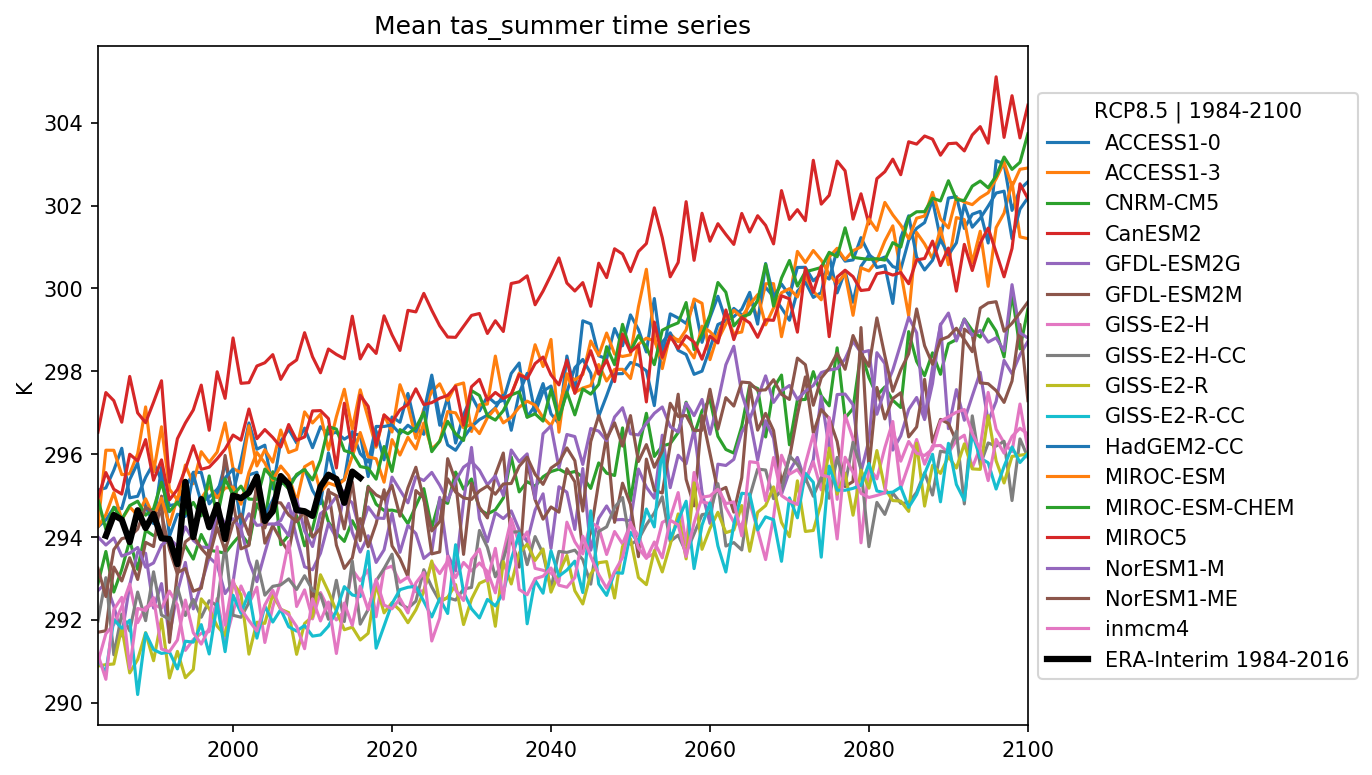

In [86]:
# perform check on a single division, lets say, 
futures85 = lasso_all_85_cmip5_dict["western_US"]
era_features = X_seasonal_dict["western_US"]
plot_unit_time_series(futures85, era_features, feature='tas_summer', units = "K")

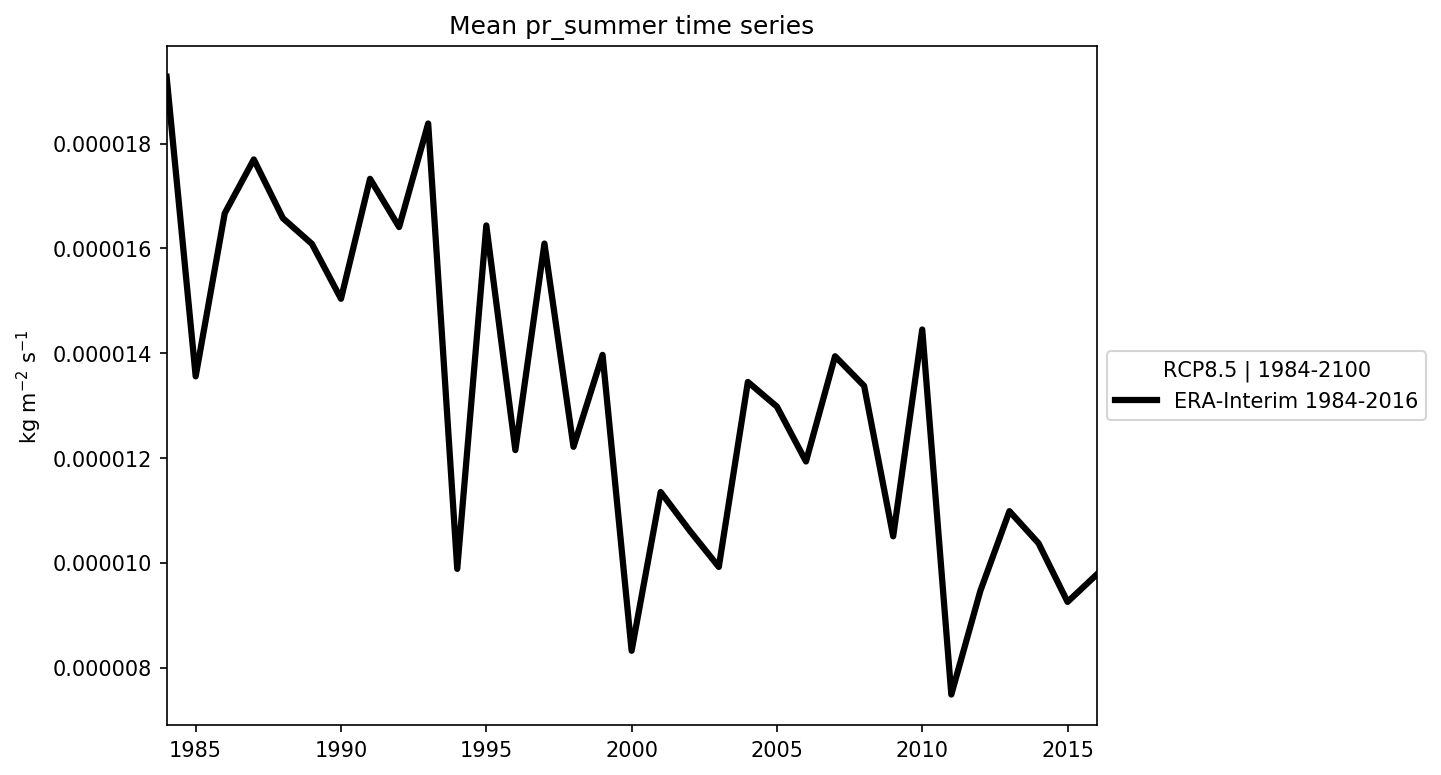

In [87]:
# perform check on a single division, lets say, 
futures85 = lasso_all_85_cmip5_dict["western_US"]
era_features = X_seasonal_dict["western_US"]
plot_unit_time_series(futures85, era_features, feature='pr_summer', units = "kg m$^{-2}$ s$^{-1}$")

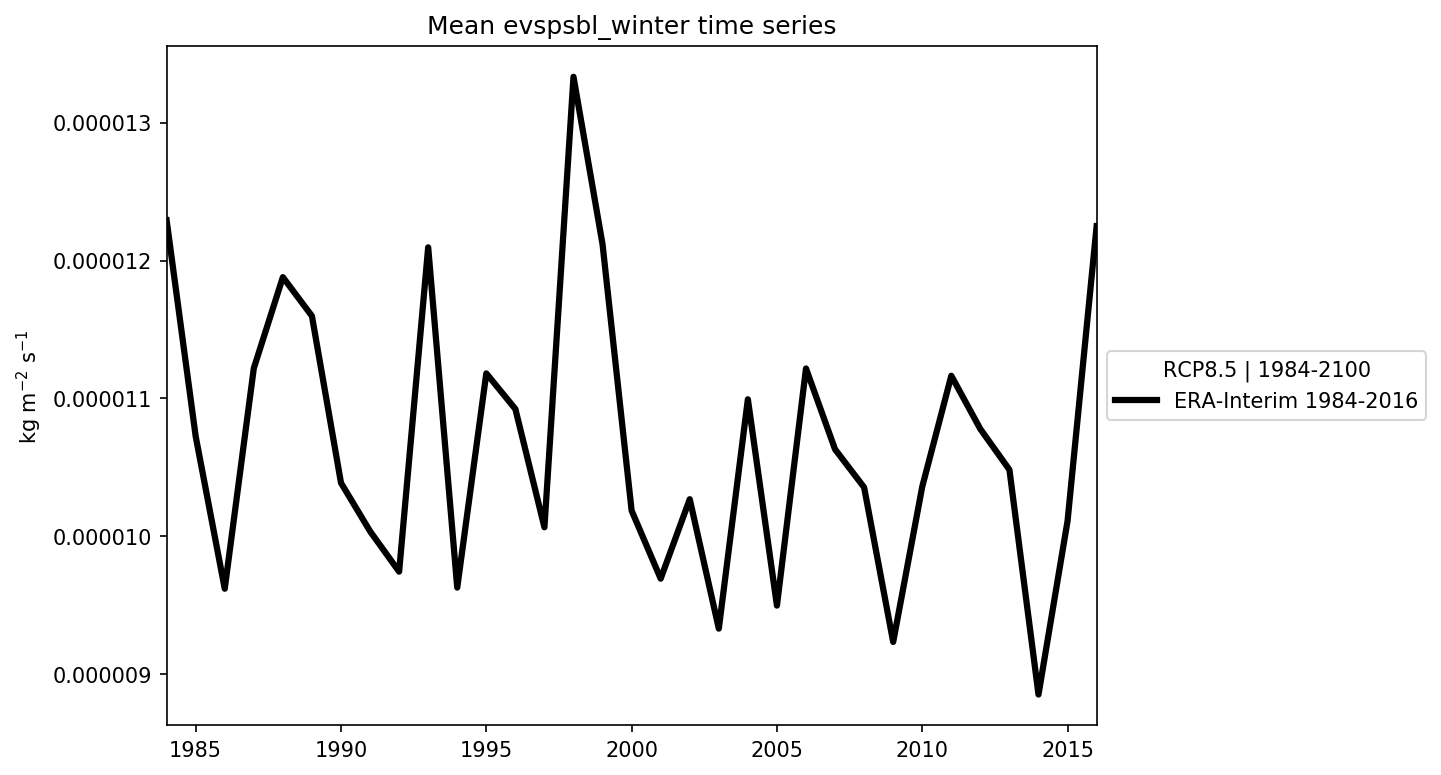

In [88]:
# perform check on a single division, lets say, 
futures85 = lasso_all_85_cmip5_dict['Marine Regime Mountains']
era_features = X_seasonal_dict['Marine Regime Mountains']
plot_unit_time_series(futures85, era_features, feature='evspsbl_winter', units = "kg m$^{-2}$ s$^{-1}$")

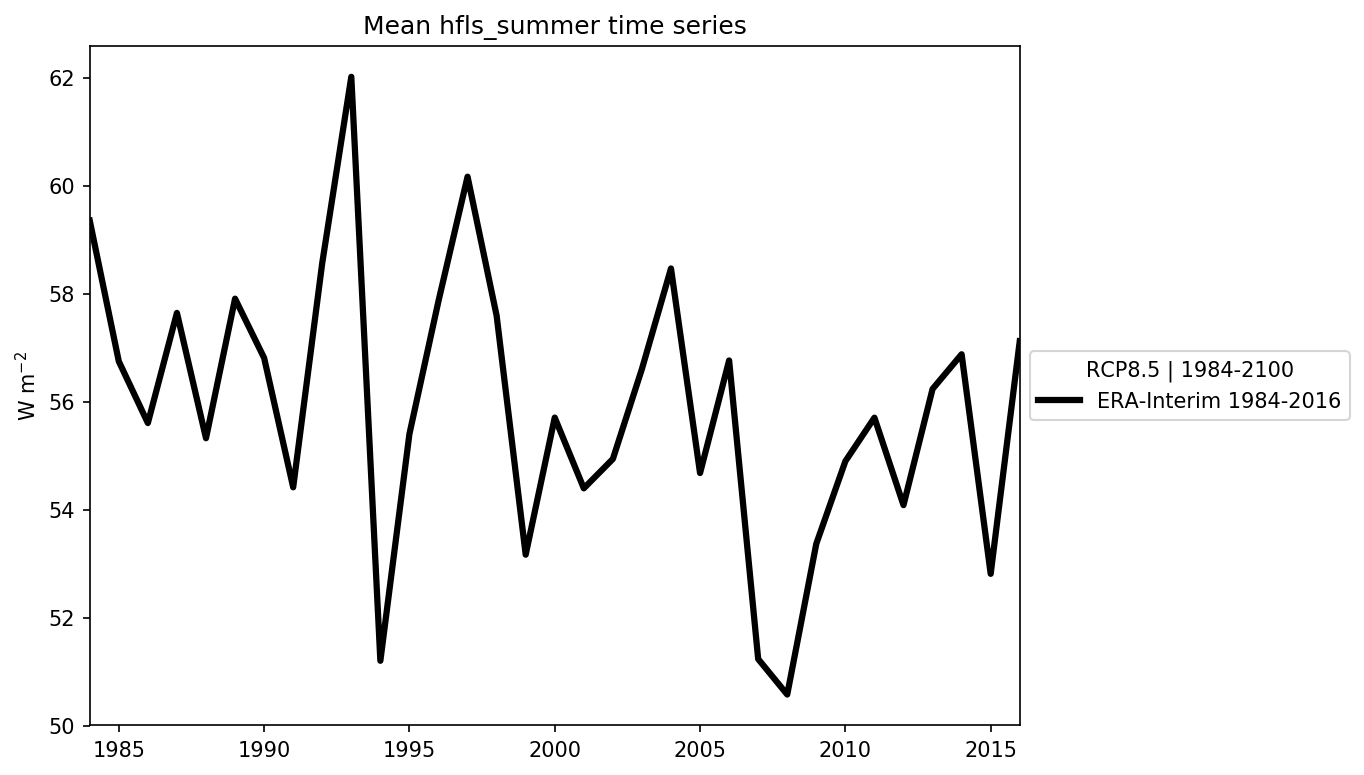

In [89]:
# perform check on a single division, lets say, 
futures85 = lasso_all_85_cmip5_dict['Marine Regime Mountains']
era_features = X_seasonal_dict['Marine Regime Mountains']
plot_unit_time_series(futures85, era_features, feature='hfls_summer', units = "W m$^{-2}$")

### Standardize CMIP5 output using historical variance and mean

- TODO: Paste description in the paper here, or vice versa, to match the final procedure that includes variance scaling. 
- The equations below outline what has to happen to predict future burn area using CMIP output
- Or to put CMIP5 output into historical context. 

- The bias of each CMIP5 model needs to be addressed. This will be done via the following equation (which are written more precicely in the manuscript). This replaces the CMIP5 bias with the historical bias. This should make it so that a time series of the historical value and the projected value are roughly aligned in the first decade of the 21st century. 

$$x_{bias-corrected_{CMIP5}}=(x_{CMIP5_{1984-2100}}-\overline{x_{CMIP5_{1984-2100}}})+\overline{x_{ERA_{1984-2016}}}$$

- Make the CMIP5 model variance ($\sigma^{2}$) and standard deviation ($\sigma$) match the historical feature values observed by ERA-Interim
    - Only do this after being able to defend it as NEEDED

$$ x_{i_{CMIP_{1984-2100}}}^{\prime} = x_{i_{CMIP5_{1984-2100}}} \times \frac{ \sigma_{ERA_{1984-2016}}} {\sigma_{CMIP5_{1984-2016}} } $$

- CMIP5 model variables  need to be standardized using the following equation (where x is some variable). 

$$x^{\prime\prime}=\frac{x_{bias-corrected_{CMIP5}}-\overline{x_{historical}}}{\sigma_{historical}}$$

- $x^{\prime\prime}$ is the matrix that will be fed into the trained linear model's $predict()$ methed to estimate future wildfire burn area. 

In [90]:
def cmip_bias_correction(cmip5_df_features, era_df_features, feature, y1=1984, y2=2016) :
    """
    This function corrects the bias in CMIP5 seasonal output by using the 
    overallping years between CMIP5 output and era-reanalysis data. This is
    done by removing the 1984-2016 mean value of the cmip5 feature of interest
    and replacing it with the same years mean value from the reanlaysis data. 
    
    Parameters
    ----------
        cmip5_df_features : A pd.DataFrame of cmip5 features. [year x feature]
        era_df_features : A pd.DataFrame of era-interim features. [year x feature]. 
                          Must have the exact same names as cmip5_df_features. 
        feature : The feature (variable, predictor, what have you) to be bias 
                  corrected. 
    Return
    ------
        A np.array(dtype=float) of the cmip5 feature data array where the bias
        has been corrected. 
    """

    # Take the overlapping time period mean values for era and cmip
    era_overlap_mean   = np.array(era_df_features.loc[y1:y2, feature]).mean()
    cmip5_overlap_mean = np.array(cmip5_df_features.loc[y1:y2, feature]).mean()
    
    # Remove the CMIP5 mean value
    cmip_feature_no_bias = np.array(cmip5_df_features[feature]) - cmip5_overlap_mean
    
    # Replace the CMIP5 mean value with the reanalysis mean value 
    cmip_feature_with_era_bias = cmip_feature_no_bias + era_overlap_mean
    
    return cmip_feature_with_era_bias

### Demonstration of bias correction method

### Standardize the CMIP5 output and handle bias for all divisions. 
- Save as new dictionary
- TODO: handle trends within the overlap period. This could be important if sigma is driven by a trend rather than year to year variability.

In [91]:
def bias_correct_cmip(feature, div, model_name, X, y1=1984, y2=2016, inspect=False) : 
    """
    Scales the variance of a CMIP5 model simulated feature to match
    the variance observed by ERA-Iterim. The variance is scaled using
    the overlapping years 1984-2016, all relevant sigmas are from 
    detrended series. 

    # TODO: Regression TYPE NEEDED IN SAVE INFORMATION. 

    Parameters
    ----------
        feature: str, the name of the feature being scaled. 
        div : the division data being scaled. used for getting correct detrended sigma. 
        X : pd.DataFrame, the CMIP5 dataframe with the feature to be scaled. Index of X
            used in regression within method. 

    Return
    ------
        x_fully_calibrated : np.array, where the detrended sigma (interannual) variance was scaled
                             so that np.std(x[y1:y2]) == era_ref_std and such that the historical
                             mean for y1-y2 matches era. Fully bias corrected. 
        sigma_ratio : ratio of y1:y2 detrended sigmas (era_ref_std / cmip_x_sub_flat_sigma).
                      good reference for figuring out how bad cmip simulates a given features. 
    """

    # tolerance for difference in historical overlap period 
    # sigma between model and observations 
    tol = 1e-14

    # Get the mean and std values of the era_df_features to use to standardize 
    # the cmip model output by
    # TODO: Replace with reading the saved values! 
    era_ref_mean = pd.read_csv(os.path.join(save_dir_base, 'feature_means.csv'), index_col=0).loc[div, feature]
    era_ref_std  = pd.read_csv(os.path.join(save_dir_base, 'feature_std.csv'), index_col=0).loc[div, feature]

    # Get mask of overlapping years for scaling
    overlap_mask = ( X.index.values >= y1 ) & (X.index.values <= y2)

    years = X.index.values.copy()

    # Get the series to be scaled as numpy.array
    x = X.loc[:, feature].values.copy()
    #print(x)
    x_lm = stats.linregress(years, x)
    x_linear_fit = years*x_lm.slope + x_lm.intercept
    x_flat = signal.detrend(x)

    # Get the historical overlap years with slope and offset 
    # NOTE: In false statement, this is how I first did this, 
    # NOTE: flattening the whole series then subsetting, but
    # NOTE: it makes more sense to detrend using local slope, 
    # NOTE: not 1984-2100 slope. 
    if False :
        x_sub_flat = x_flat[overlap_mask].copy()
    else :
        x_sub = x[overlap_mask].copy()
        x_sub_flat = signal.detrend(x_sub)

    x_sub_flat_sigma = np.std(x_sub_flat)
        
    # Ratio to scale the time series by. 
    sigma_ratio = era_ref_std / x_sub_flat_sigma

    # Make sure scaling makes ref period sigma match
    d = np.abs(era_ref_std - np.std(x_sub_flat * sigma_ratio))
    if d > tol :
        raise ValueError("The scaling did not work. ")

    # use the ratio from the overlap period to scale the 
    # flattened longer time period 
    x_flat_scaled = x_flat * sigma_ratio
    
    # Add the slope and offset back into the time series 
    x_calibrated = x_flat_scaled + x_linear_fit

    # Now, replace the offset of x_calibrated with the historical mean
    # value for the overlap period
    x_calibrated_sub_mean = np.mean(x_calibrated[overlap_mask])

    # Seasonal sigma and overlap period offset both bias corrected 
    # i.e. replace cmip y1:y2 mean with era y1:y2 mean. 
    x_fully_calibrated = (x_calibrated - x_calibrated_sub_mean) + era_ref_mean
    
    if inspect : 

        fig_save_dir = os.path.join(save_dir_base, "bias_correction_curves")
        if not os.path.isdir(fig_save_dir) :
            os.mkdir(fig_save_dir)
            
        save_name = os.path.join(fig_save_dir, div.replace("/"," ")+"_"+feature+"_"+model_name+".png")
        
        plt.figure(dpi=150)
        plt.plot(years, x, label="x original")
        plt.plot(years, x_linear_fit, label = "x-linear fit")
        plt.plot(years, x_calibrated, "--", label="x variance calibrated")
        plt.axhline(y=era_ref_mean, linestyle="--", color="k", label="era reference mean")
        plt.plot(years, x_fully_calibrated, label="fully calibrated")
        plt.legend()
        plt.title(feature +" "+model_name +" scaled by %f factor" % sigma_ratio)
        plt.savefig(save_name)
        plt.close()

    return x_fully_calibrated, sigma_ratio

In [94]:
def standardize_cmip(div, cmip_dict, era_df_features, inspect=False) : 
    """
    Standardizes historical output using era reanlysis data fields. The 
    cmip5 model output bias is first corrected using cmip_bias_correction()
    then then standardized using historical (1984-2016) variance and width. 
    
    Parameters
    ----------
        cmip5_dict : A dictionary of CMIP5 output in pd.DataFrames. This 
                     function will loop over these models creating Z. 
        era_df_features : a pd.Dataframe of era features. Must exactly match
                          the features (columnames) in cmip5_dict dataframes. 
                          ERA feature means and standard deviations are 
                          calculated using this dataframe. 
                          
        Return
        ------
            A dictionary of pd.Dataframe where the keys are cmip5 model names
            and the values are the features standarized using historical (era)
            mean and variance. 
    """
    
    # Don't want any changes to be made outside of function 
    era_df_features = era_df_features.copy()
    
    # Read the mean and std values of the era_df_features to use to standardize 
    # the cmip model output by
    era_ref_mean = pd.read_csv(os.path.join(save_dir_base, 'feature_means.csv'), index_col=0).loc[div, :]
    era_ref_std  = pd.read_csv(os.path.join(save_dir_base, 'feature_std.csv'), index_col=0).loc[div, :]
        
    # A dictionary to store the standardized output 
    Z_futures_dict = {}
        
    # Get model names to loop over 
    model_names = cmip_dict.keys()
    n_models    = len(model_names) 
    
    # A DataFrame to record how much cmip model sigma are scaled 
    sigma_scale_df = pd.DataFrame(np.nan, columns=era_ref_mean.index.values, index=model_names)
    
    for model_name in model_names : 

        if inspect :
            print("Standardizing %s model output" % model_name)

        # Get the CMIP5 features dataframe from the futures dict
        cmip_df_features = cmip_dict[model_name].copy()
        cmip_years = np.array(cmip_df_features.index.values.copy())
        features = cmip_df_features.columns.values

        # Use pd.DataFrame for nice storage. 
        Z_future_df = pd.DataFrame(0, columns=features, index=cmip_years)
        
        # Standardize (using historical mean and variance) 
        # the columns of these CMIP5 output 
        for feature in features : 
            
            # Scale sigma, try statement will throw ValueError when 
            # feature data does not exist. 
            try : 
                
                x_calibrated, sigma_ratio = bias_correct_cmip(feature, div, model_name, cmip_df_features, inspect=inspect)
                sigma_scale_df.loc[model_name, feature] = sigma_ratio
                #print(model_name + " sigma ratio: %f" % sigma_ratio)
                
                # Convert to z using historical values 
                z = ( x_calibrated - era_ref_mean.loc[feature] ) / era_ref_std.loc[feature]

                # Store the value
                Z_future_df.loc[:, feature] = z.copy()
            
            except ValueError :
                
                # If these data do not exist replace 0 with nan
                # so it is clear the data were travered
                Z_future_df.loc[:, feature] = np.nan

            # old way before scaling sigma came into play
            ## Handle offset bias
            #feature_bias_corrected = cmip_bias_correction(cmip_df_features, era_df_features, feature)
            ## Standardize with historical values.
            #Z_future_df.loc[:,feature] = (feature_bias_corrected - era_ref_mean[feature]) / era_ref_std[feature]
        
        # Store in the dictionary
        Z_futures_dict[model_name] = Z_future_df   
    
    #print(sigma_scale_df)
        
    return Z_futures_dict, sigma_scale_df

In [92]:
def make_cmip5_Z_dict(regression_name, rcp, cmip_dict, X_seasonal_dict, inspect=False) :
    """
    
    Parameters
    ----------
        regression_name : str, The name of the regression 
        rcp : str, the desired RCP associated with the regression_name
        cmip_dict : A cmip5 dictionary created by get_CMIP5_features(), 
                    containing cmip5 data for non-zero coefs of associated
                    regression, for each ecoregion
        X_seasonal_dict : dictionary of pd.DataFrame, containing divisions
                          (index) by features (rows) of era-iterim data
                          used to train regressions and make ceofs.
                          
    return
    ------
        Z_cmip_dict : A dictionary where cmip5 data have been expressed in terms
                      of historical variance after being bias corrected. 
    """
    
    # Create descriptive file save name
    f1 = regression_name + "_" + "Z_cmip_" + rcp + "_dict.obj"
    print("Creating: " + os.path.join(save_dir_base, f1) ) 
    
    # Create an empty diction to store division Z dictionaries
    Z_cmip_dict = {}
    Z_sigma_scale_dict = {}
    
    for div in cmip_dict.keys() : 
        Z_cmip_dict[div], Z_sigma_scale_dict[div] = standardize_cmip(div, cmip_dict[div], X_seasonal_dict[div], inspect)

    # And save them for analysis
    with open(os.path.join(save_dir_base, f1), 'wb') as fp:
        pickle.dump(Z_cmip_dict, fp)
        
    # And save them for analysis
    f2 = regression_name + "_sigma_scale_cmip_" + rcp + "_dict.obj"
    with open(os.path.join(save_dir_base, f2), 'wb') as fp:
        pickle.dump(Z_sigma_scale_dict, fp)   
        
    return Z_cmip_dict, Z_sigma_scale_dict

#### Standardize the features for each division for :
- **Each regression type**
    - **RCP** 

#### Here is the absurd nesting of the functions that standardize CMIP5 output
- make_cmip5_Z_dict(regression_name, rcp, cmip_dict, X_seasonal_dict)
    - standardize_cmip(div, cmip5_dict[div], X_seasonal_dict[div])
        - cmip_bias_correction(cmip5_dict[div], X_seasonal_dict[div], feature)

In [95]:
Z_lasso_all_cmip_85_dict, _   = make_cmip5_Z_dict("lasso_all", "85", lasso_all_85_cmip5_dict, X_seasonal_dict)
Z_lasso_plant_cmip_85_dict, _ = make_cmip5_Z_dict("lasso_plant", "85", lasso_plant_85_cmip5_dict, X_seasonal_dict)
Z_lasso_atmos_cmip_85_dict, _ = make_cmip5_Z_dict("lasso_atmos", "85", lasso_atmos_85_cmip5_dict, X_seasonal_dict)

Z_lasso_all_cmip_45_dict, _   = make_cmip5_Z_dict("lasso_all", "45", lasso_all_45_cmip5_dict, X_seasonal_dict)
Z_lasso_plant_cmip_45_dict, _ = make_cmip5_Z_dict("lasso_plant", "45", lasso_plant_45_cmip5_dict, X_seasonal_dict)
Z_lasso_atmos_cmip_45_dict, _ = make_cmip5_Z_dict("lasso_atmos", "45", lasso_atmos_45_cmip5_dict, X_seasonal_dict)

Creating: ../Data/Analysis/no_logs/lasso_all_Z_cmip_85_dict.obj
Creating: ../Data/Analysis/no_logs/lasso_plant_Z_cmip_85_dict.obj
Creating: ../Data/Analysis/no_logs/lasso_atmos_Z_cmip_85_dict.obj
Creating: ../Data/Analysis/no_logs/lasso_all_Z_cmip_45_dict.obj
Creating: ../Data/Analysis/no_logs/lasso_plant_Z_cmip_45_dict.obj
Creating: ../Data/Analysis/no_logs/lasso_atmos_Z_cmip_45_dict.obj


Make z a pd.DataFrame Z, easier to plotting and handling

### Plot Z time series to make sure standardization and bias correction worked as planned 

In [96]:
def plot_history_future(Z, Z_futures85_dict, feature) : 
    """
    Z : pd.DataFrame, the standardized era-interim fields 
    Z_futures85_dict : pd.DataFrame, the standardized CMIP5 RCP85 fields
    Z_futures45_dict : pd.DataFrame, the standardized CMIP5 RCP45 fields
    feature : str, the feature in the passed dataframes to plot 
    
    """
    
    fig = plt.figure(dpi=200)

    ax = plt.subplot(111)
    
    for i in Z_futures85_dict.keys() : 
        Z_futures85_dict[i][feature].plot()
        if np.max(Z_futures85_dict[i][feature].values) > 1000 : 
            print("model with wack values is: " + i)
        
    #for j in Z_futures45_dict.keys() : 
    #    plt.plot(cmip_years, Z_futures45_dict[j][feature].values, c="blue", alpha=0.5)#, label="RCP 4.5")
    #    if np.max(Z_futures45_dict[j][feature].values) > 1000 : 
    #        print("model with wack values is: " + j)
        
    # Place the historical record on at the end. 
    y = Z[feature].copy()
    plt.plot(np.array(Z.index.values), y, c="k", linewidth=3)#, label="ERA-Interim")
    #ymin = np.min(y) - 5. * np.std(y)
    #ymax = np.max(y) + 10. * np.std(y)
    #plt.ylim([ymin, ymax])
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #plt.legend(loc='best')
    
    plt.xlabel("Year")
    plt.ylabel(feature + "historical [$sigma$]")
    plt.title(feature)
    plt.show()

### Our definition of standardization 
- should require that mean values for Z_cmip5 are 0 between 1984-2016
- and standard deviation of 1. 
- NOTE: Will require an update if order of operations change on subsetting. 

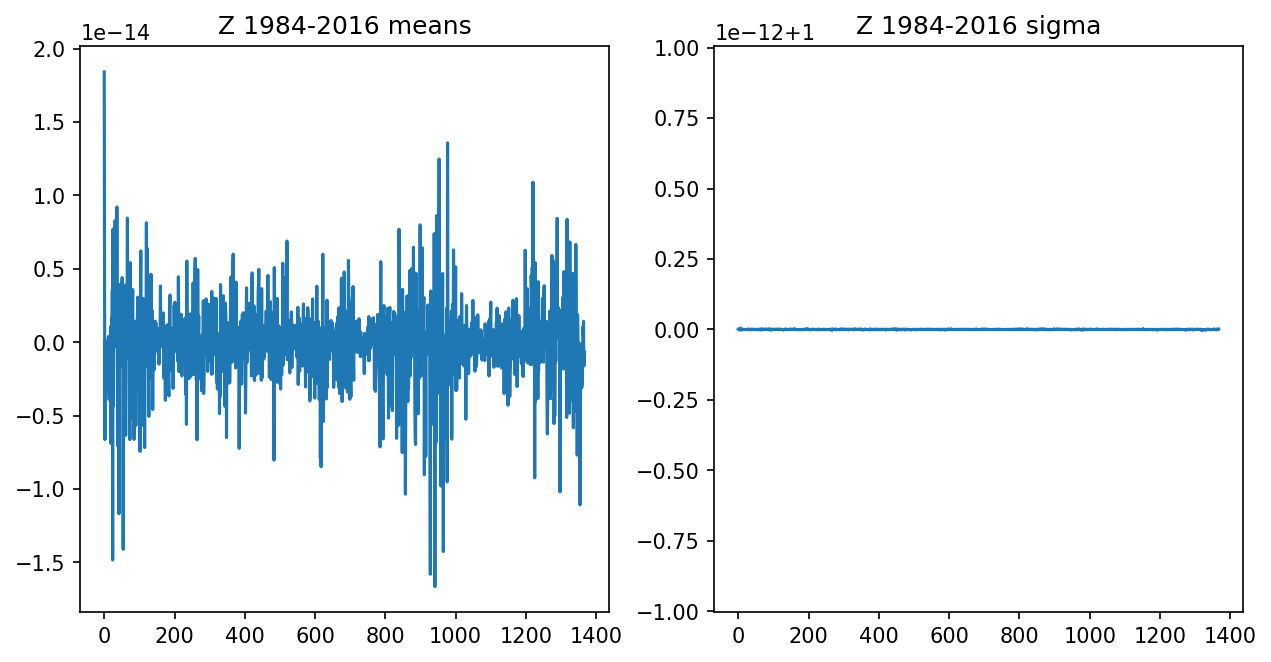

In [97]:
cmip_years = Z_lasso_all_cmip_85_dict['Marine Regime Mountains']['ACCESS1-0'].index.values
mean_vals = []
std_vals = []
for div in Z_lasso_plant_cmip_85_dict.keys() :
    for m in Z_lasso_plant_cmip_85_dict[div].keys() : 
        
        # Reverse order of operations on sigma calculation 
        z = Z_lasso_plant_cmip_85_dict[div][m]
        for feature in z.columns.values : 
            z_eg =  z.loc[:,feature].values
            #print(z_eg)
            if not np.isnan(z_eg[0]) :
                ym = (cmip_years >= 1984) & (cmip_years <= 2016)
                if False : # old way 
                    z1 = signal.detrend(z_eg)
                    std_vals.append( np.std(z1[ym]) )
                else : 
                    z1 = z_eg[ym]
                    std_vals.append( np.std( signal.detrend(z1) ) )
                    
                mean_vals.append( np.mean(z_eg[ym]) )
    
plt.figure(dpi=150, figsize=(10,5))
plt.subplot(121)
plt.plot(mean_vals)
plt.title("Z 1984-2016 means")
plt.subplot(122)
plt.plot(std_vals)
plt.title("Z 1984-2016 sigma")
plt.show()

In [98]:
print(np.min(std_vals))
print(np.max(std_vals))
print(np.min(mean_vals))
print(np.max(mean_vals))

0.9999999999999962
1.0000000000000049
-1.6666802618160684e-14
1.842297358438593e-14


Plot everything used in this analysis as a sanity check. Once checked, remove from workspace. 

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

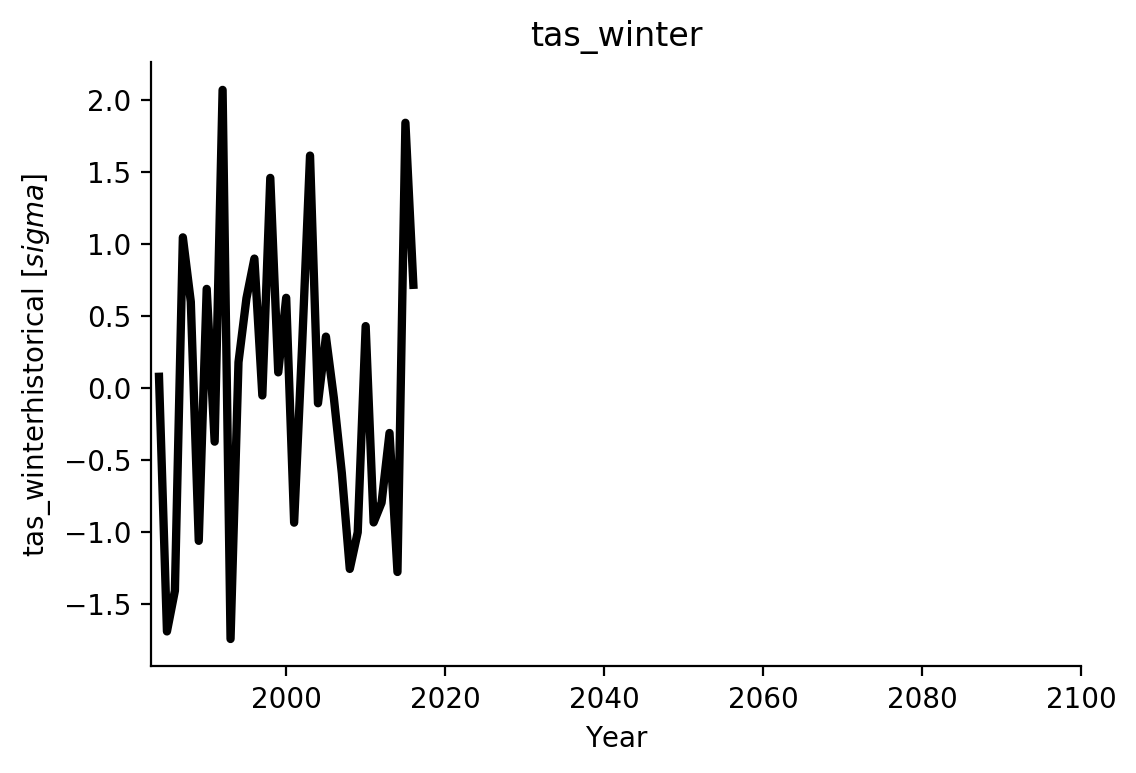

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

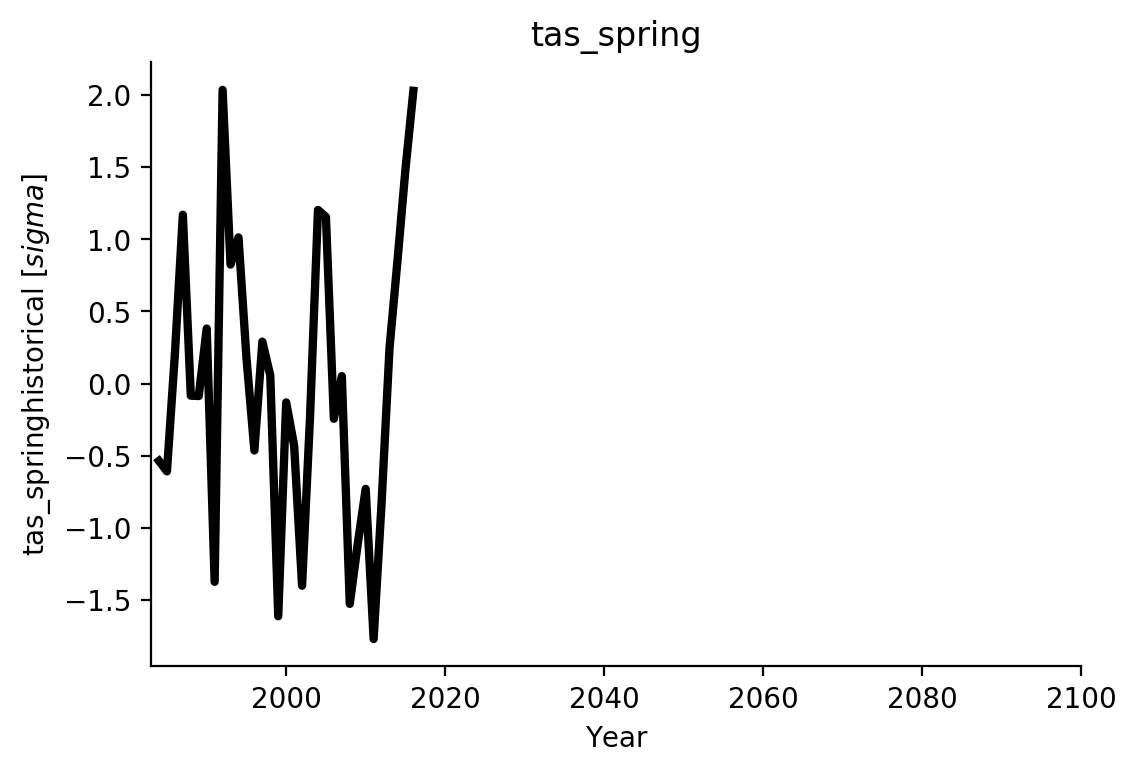

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

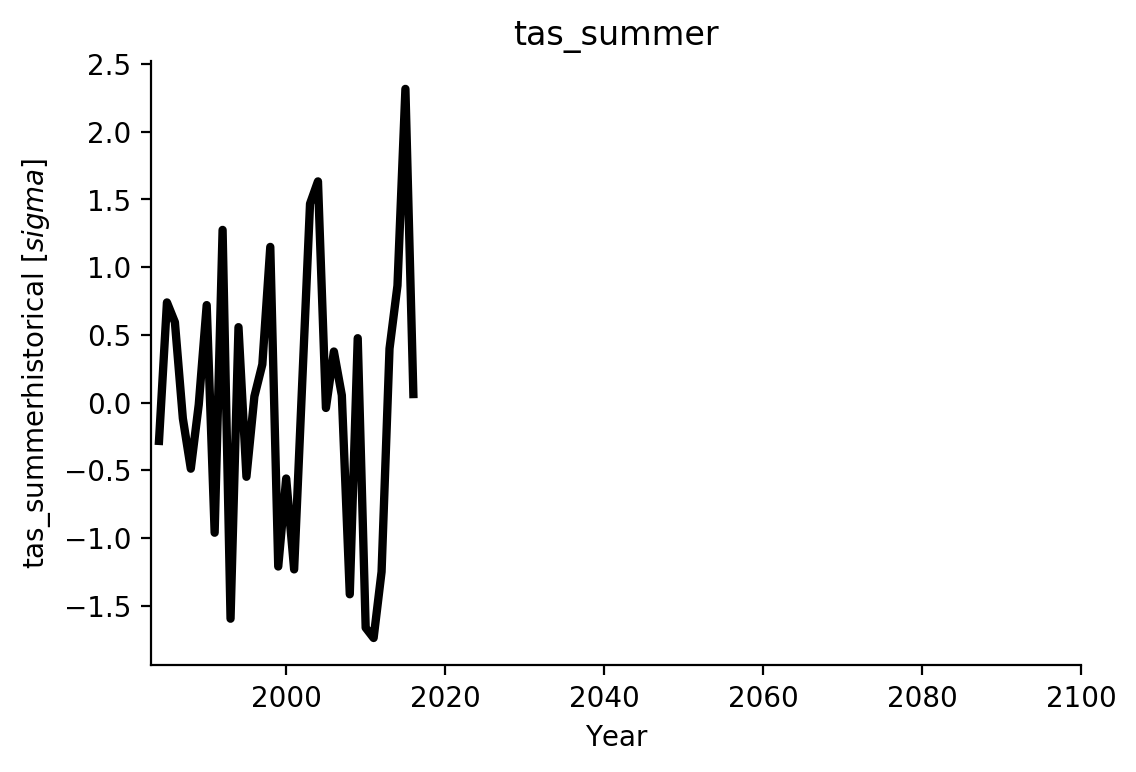

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

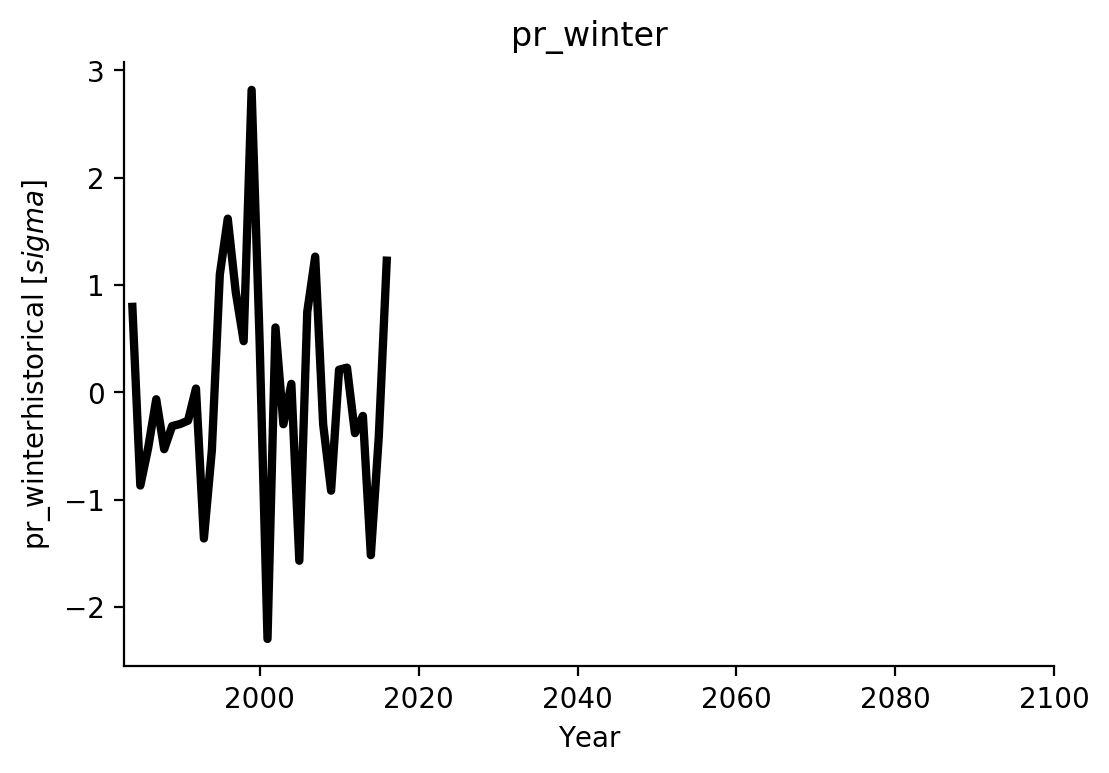

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

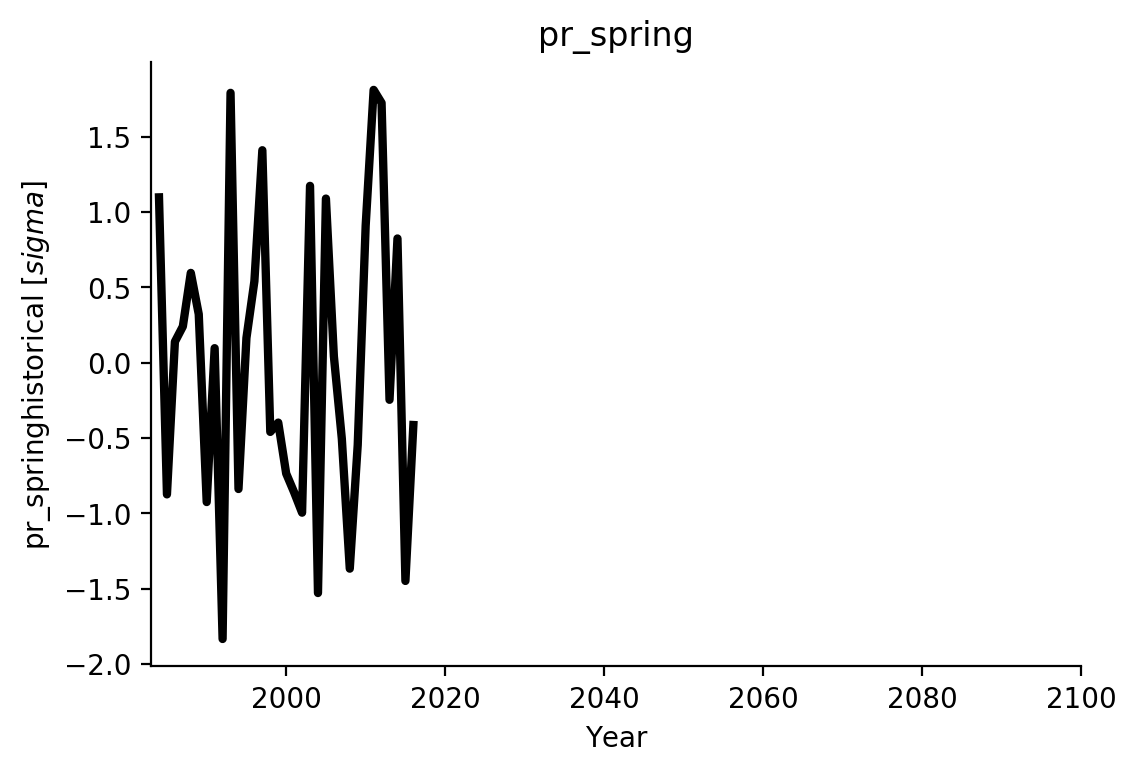

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

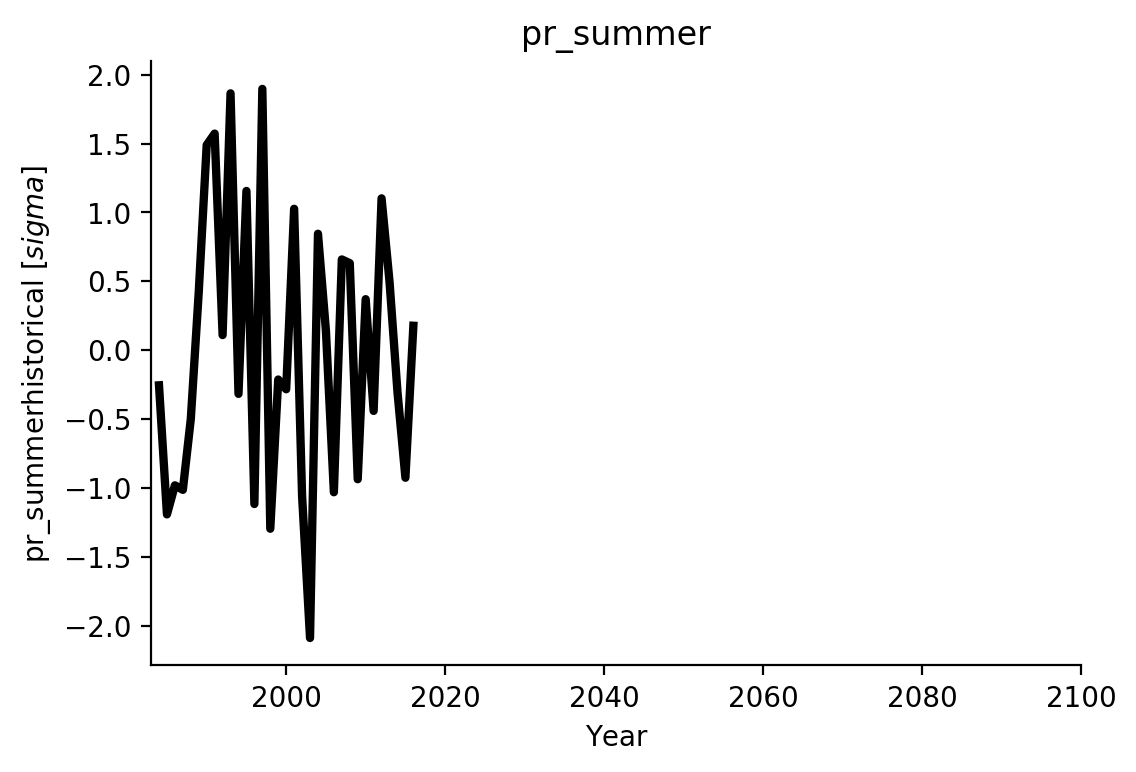

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

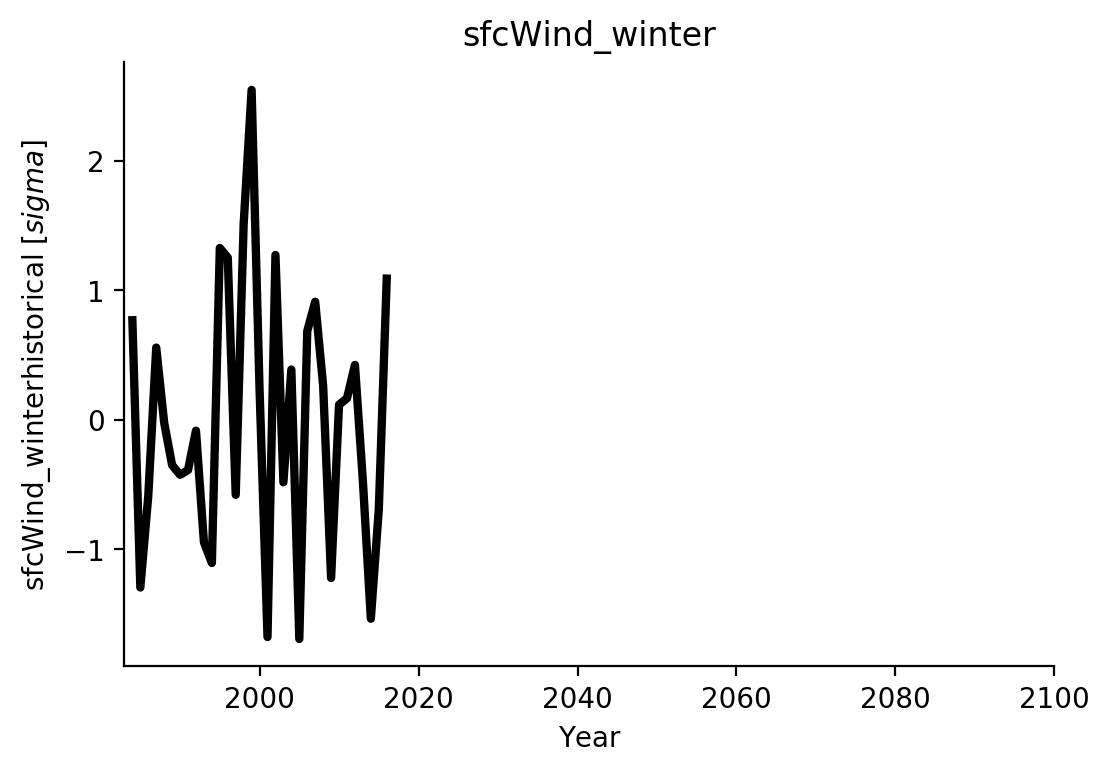

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

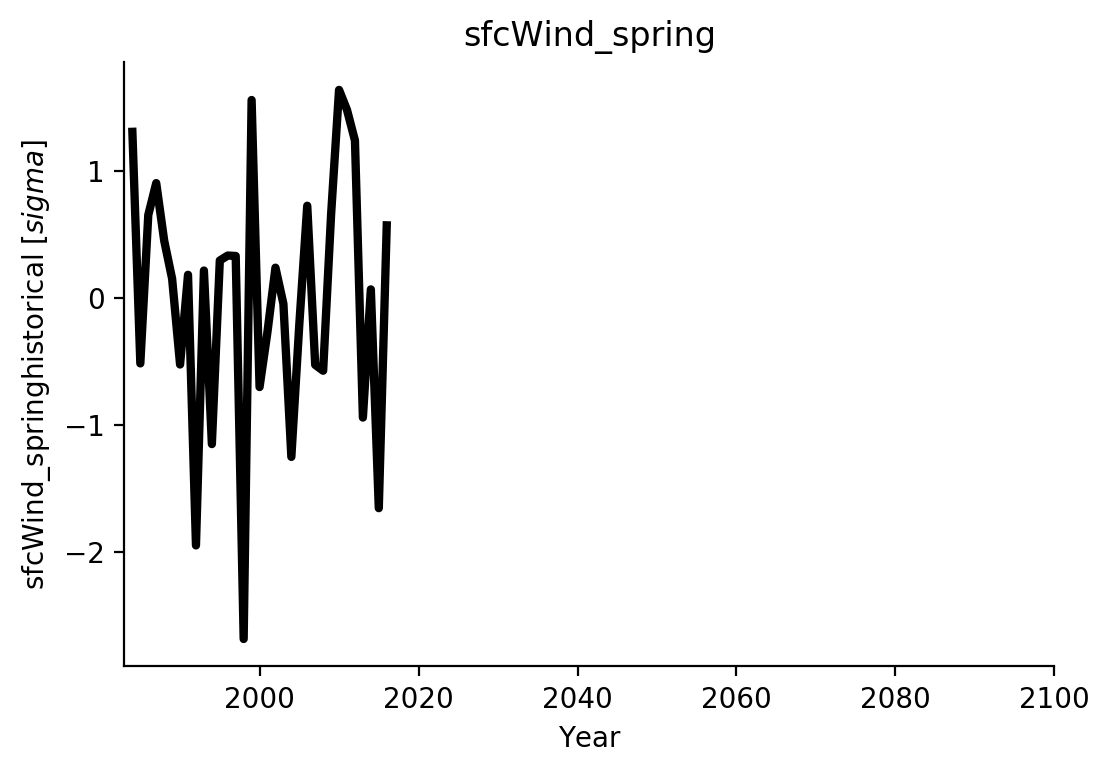

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

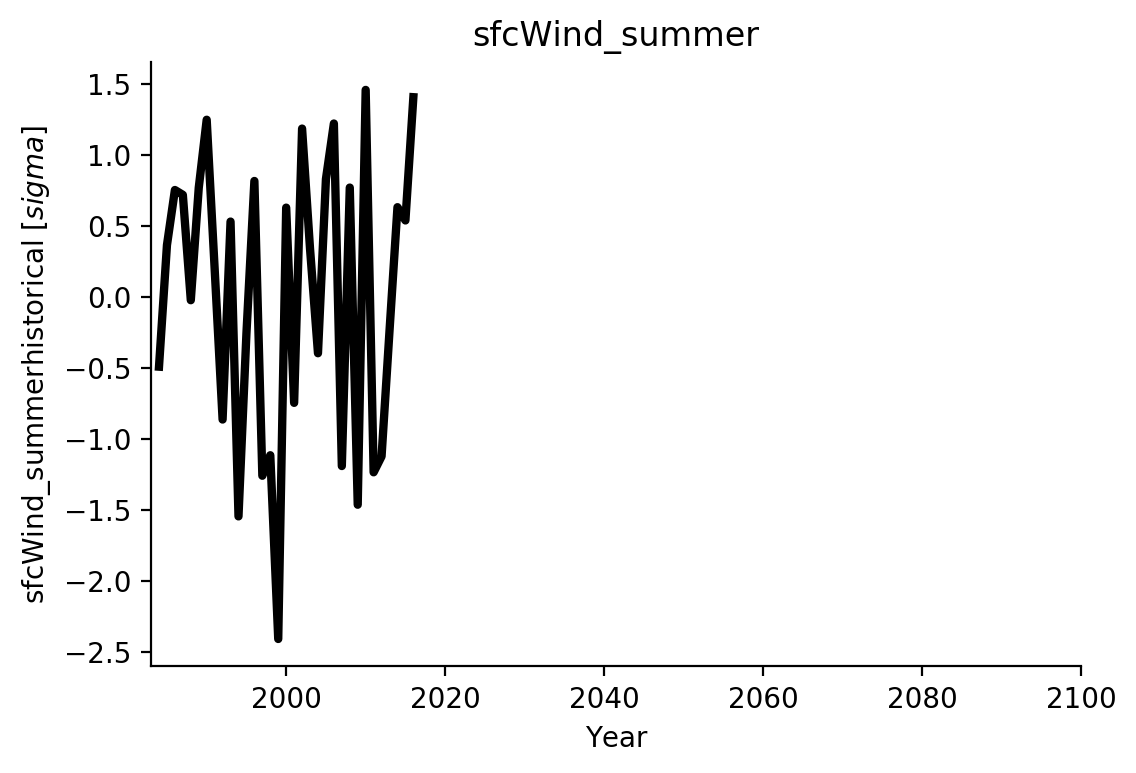

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

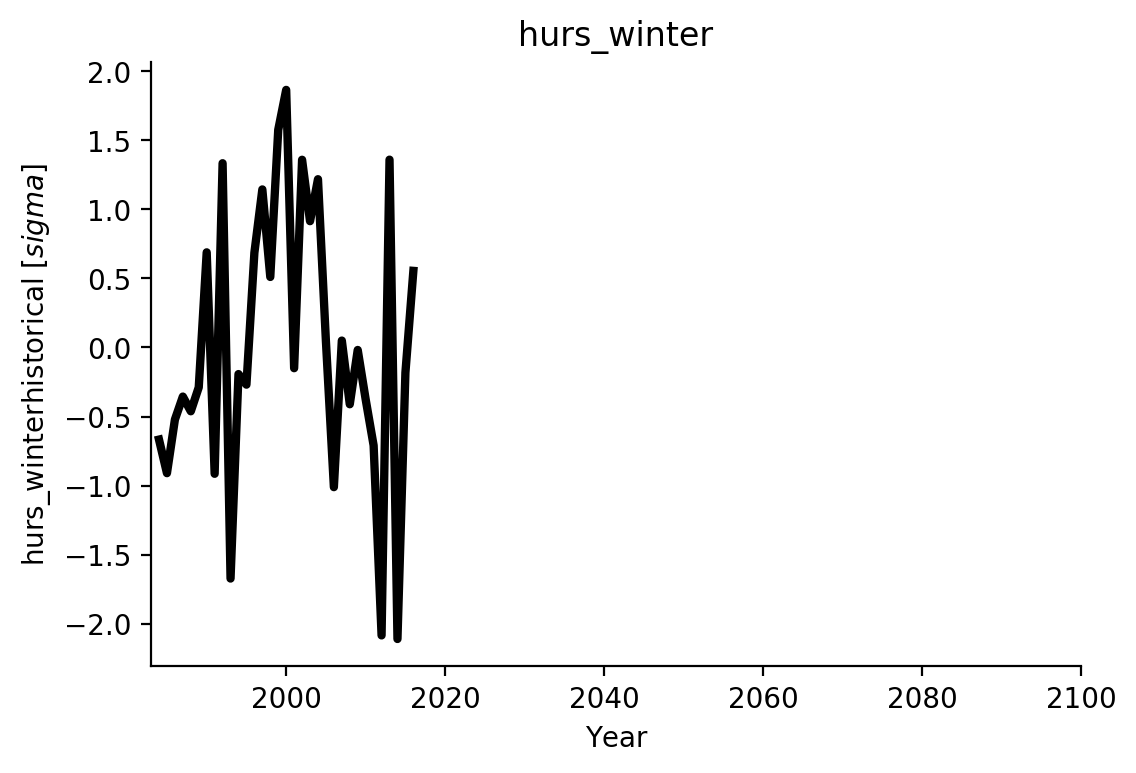

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

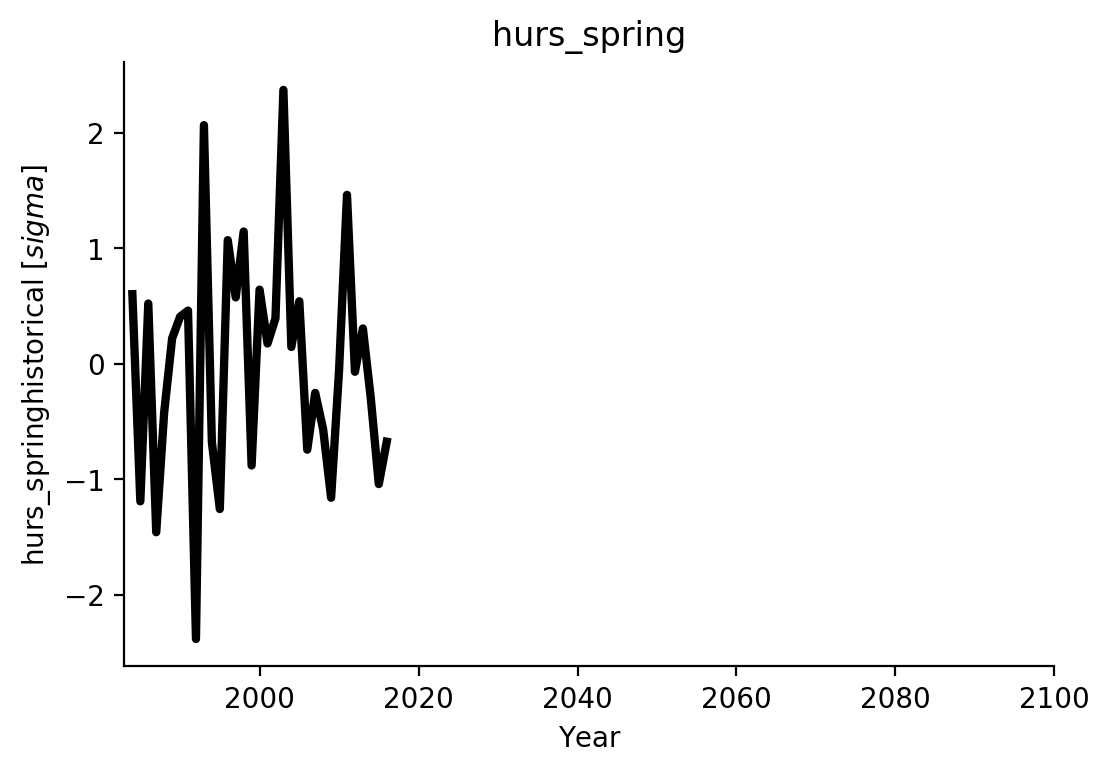

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

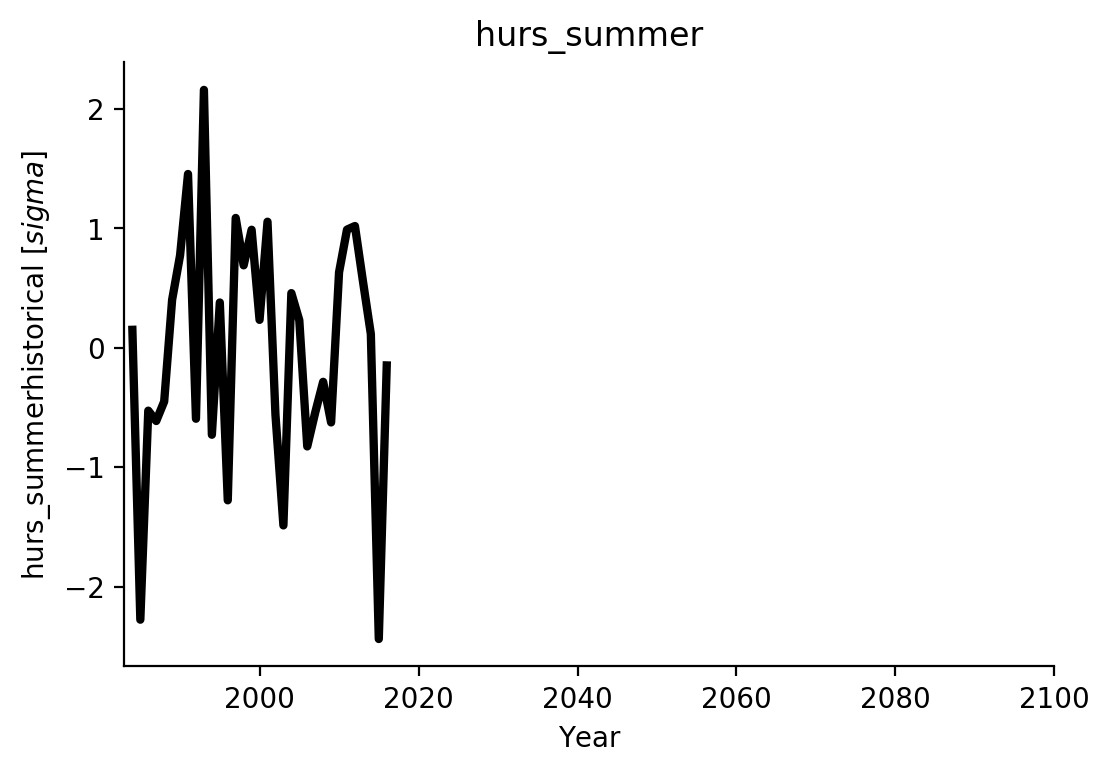

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

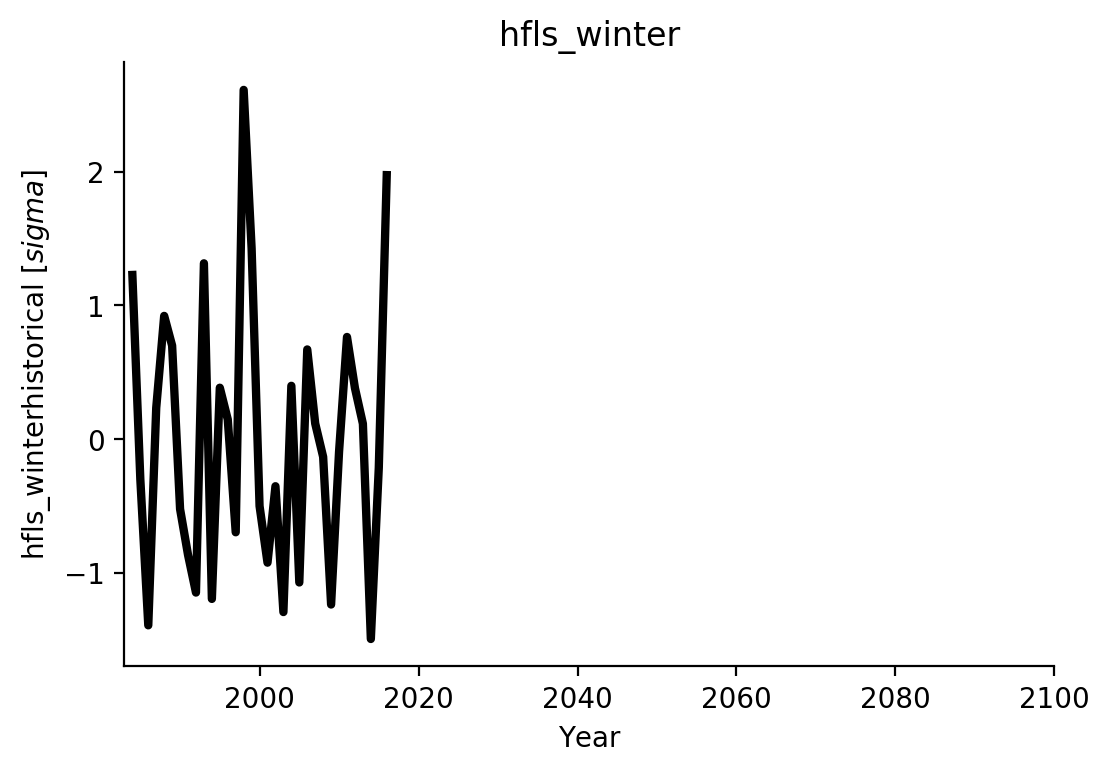

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

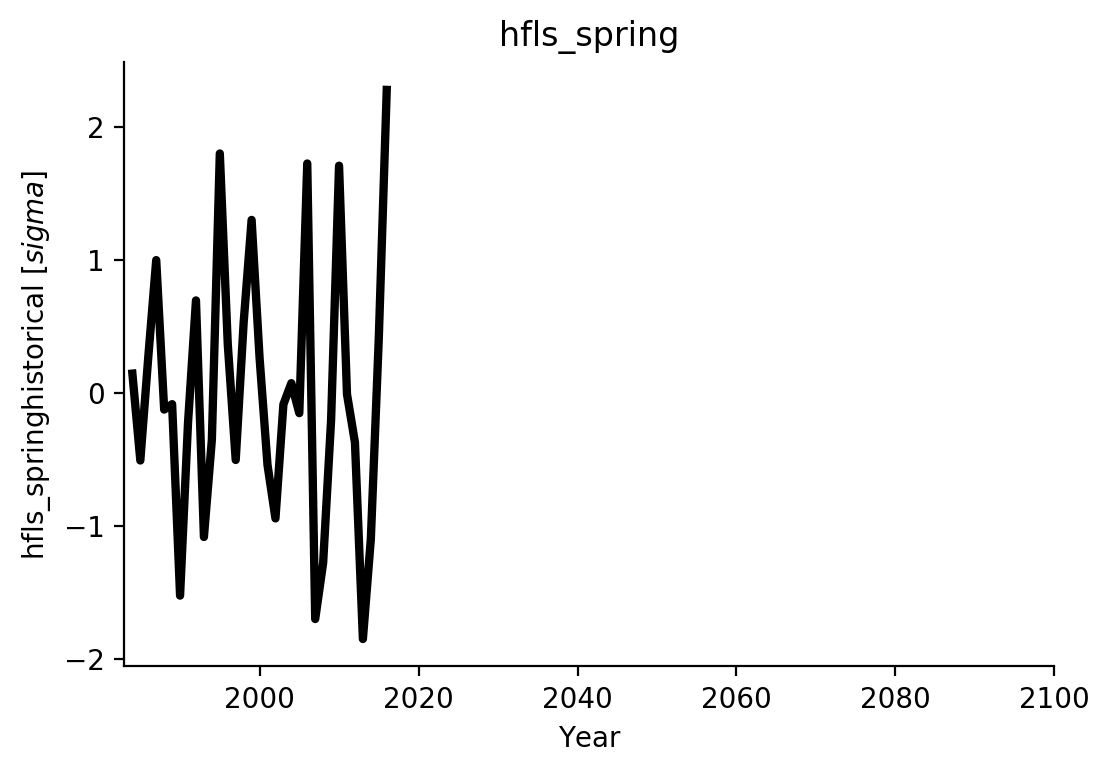

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

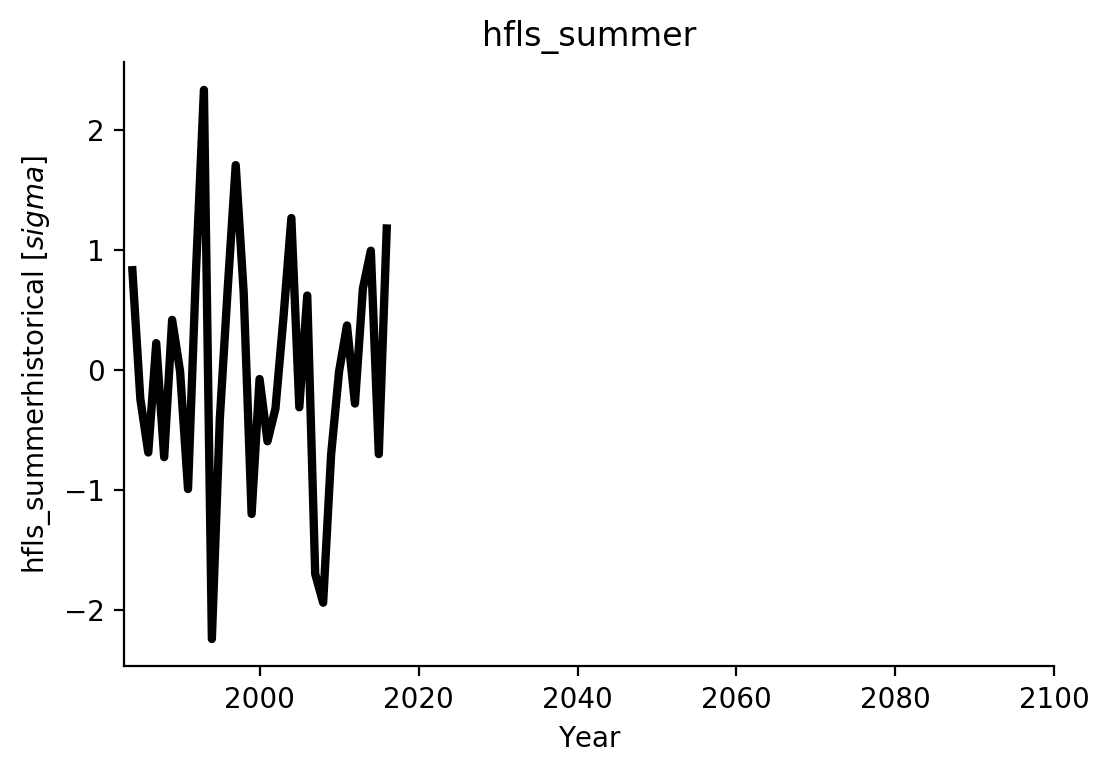

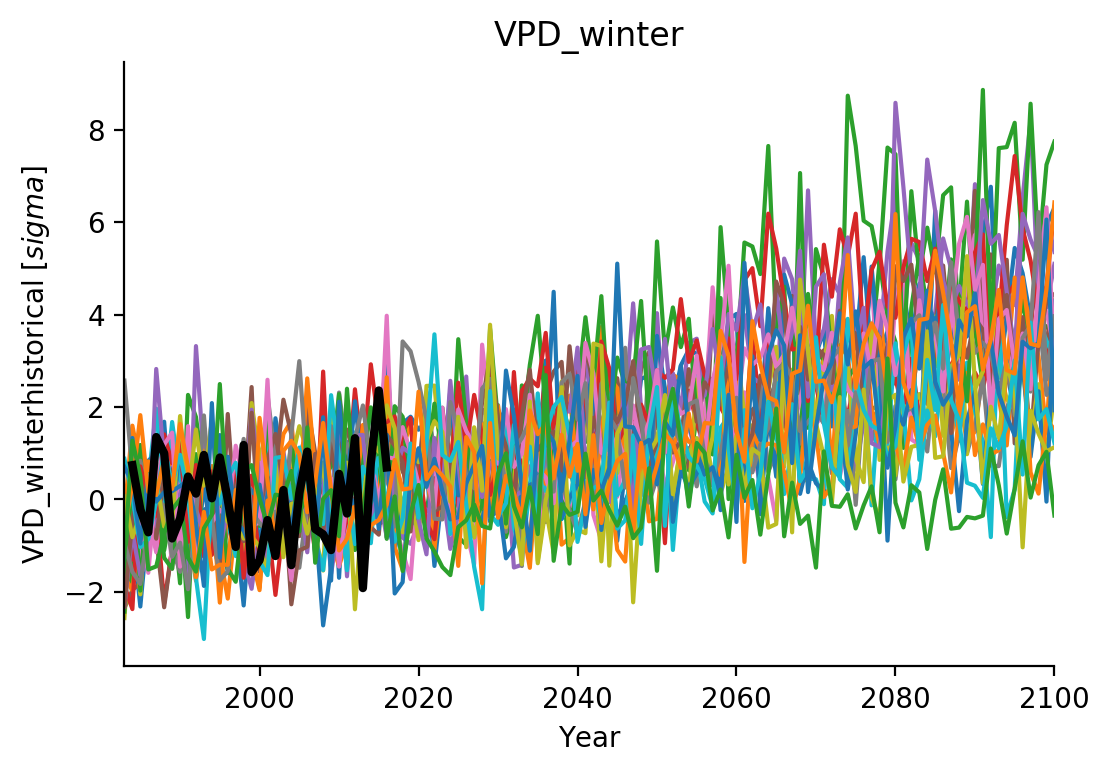

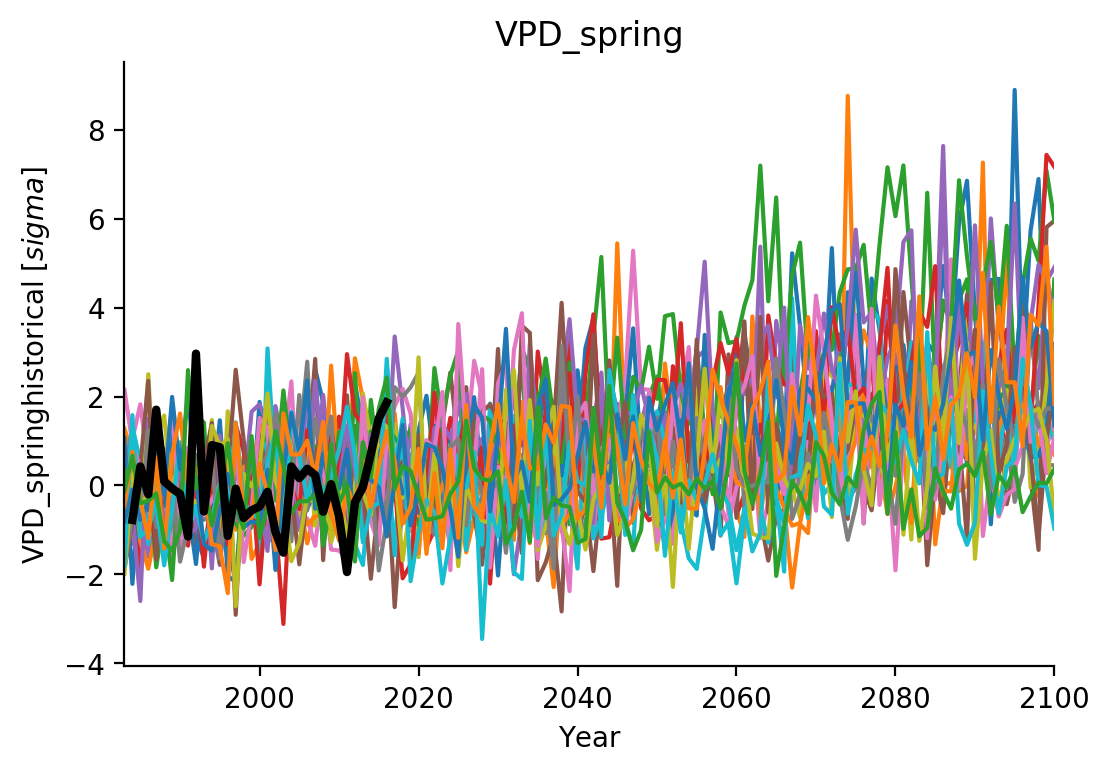

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

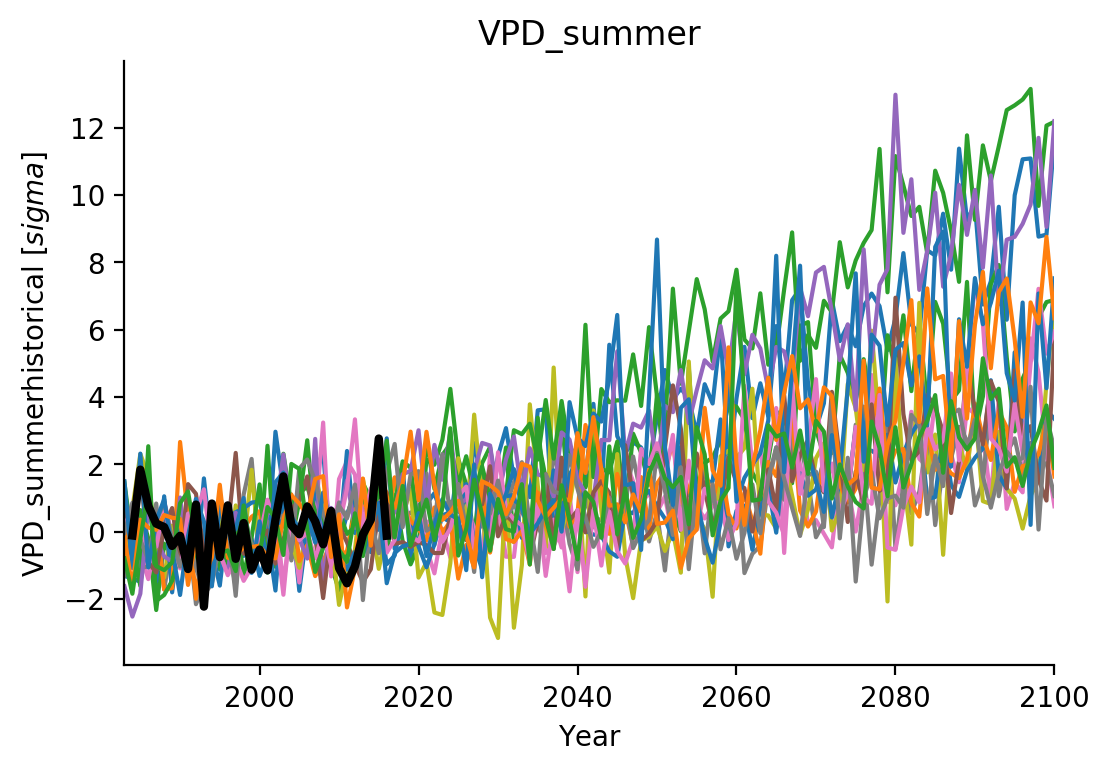

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

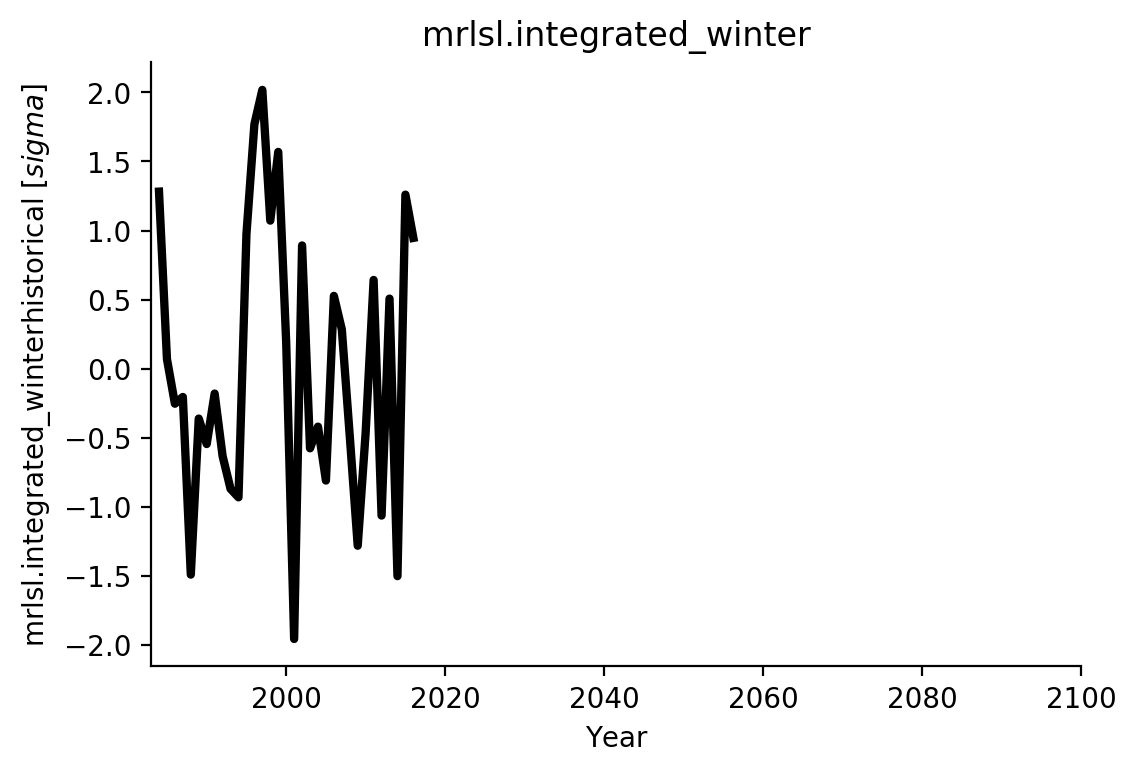

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

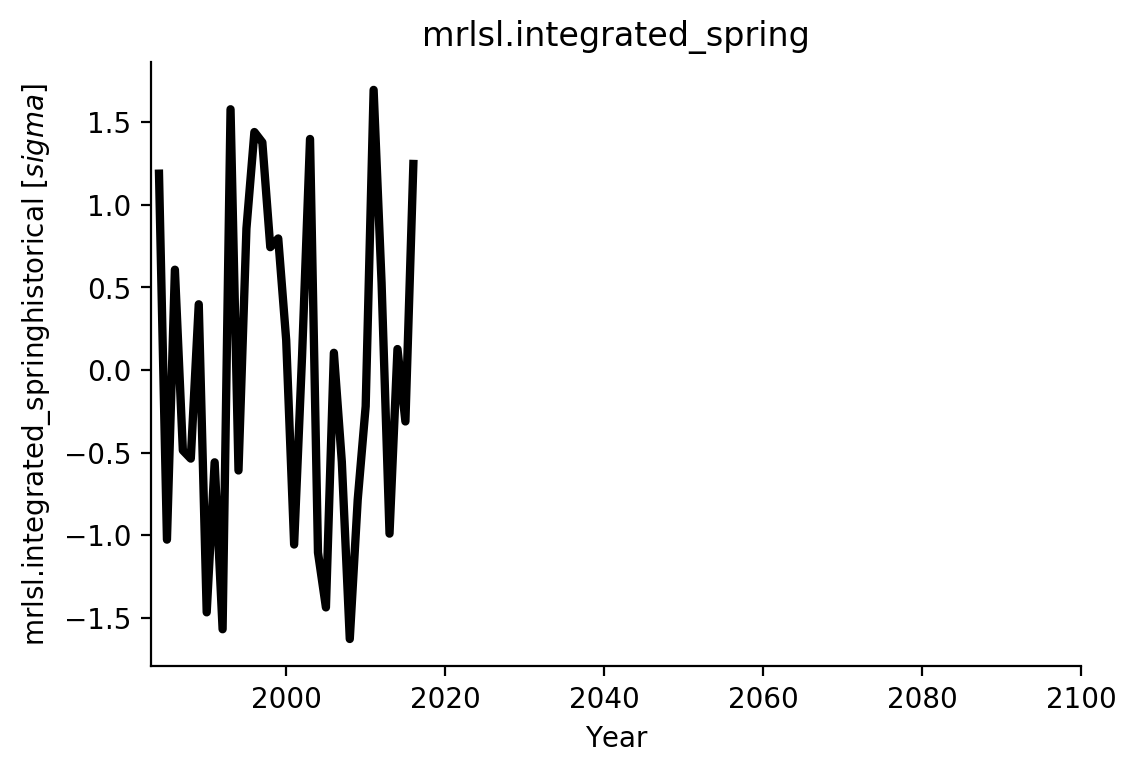

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

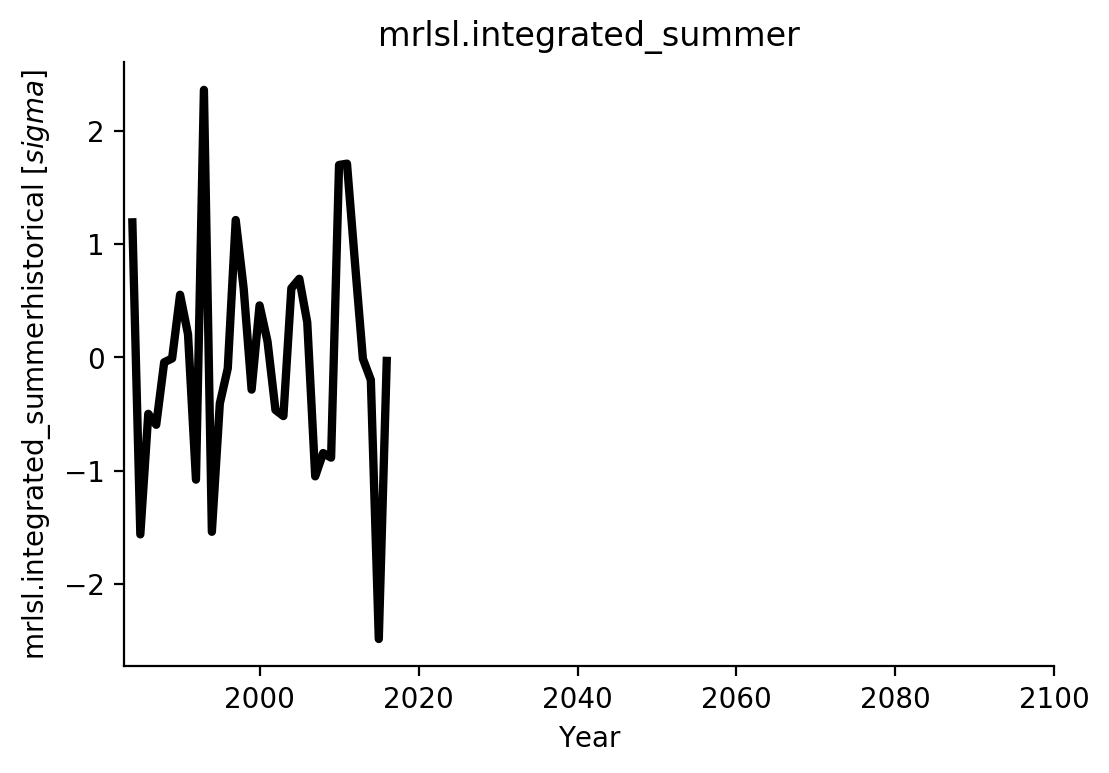

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

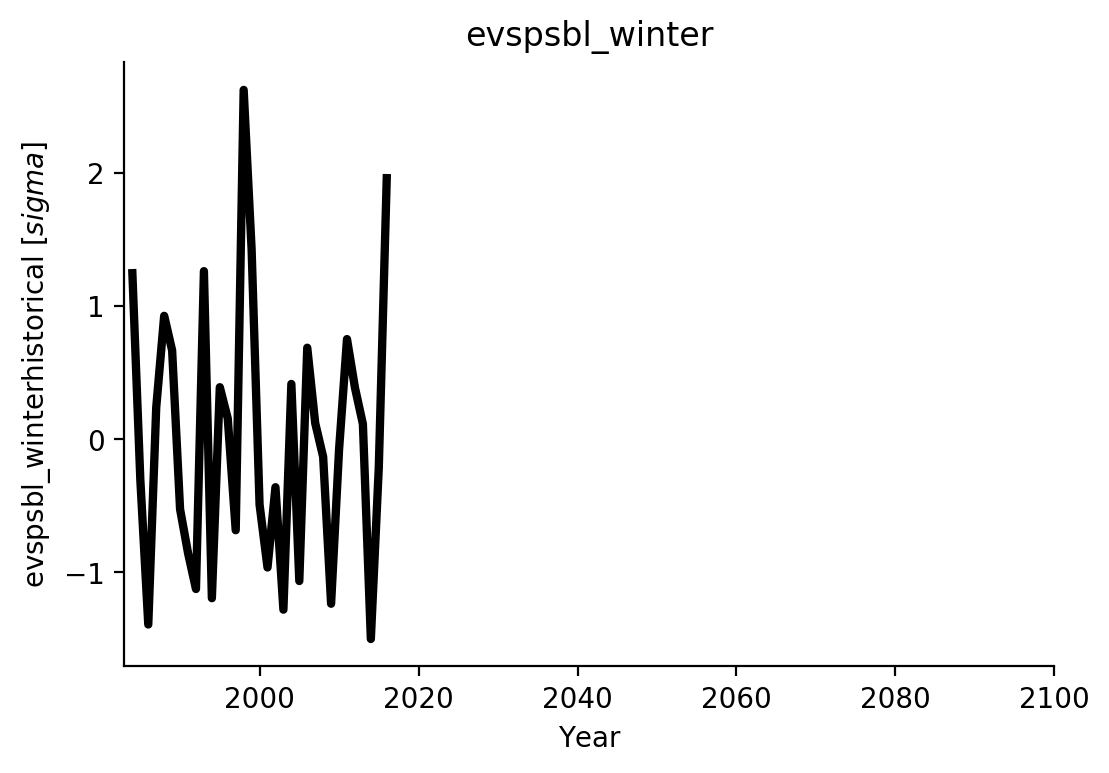

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

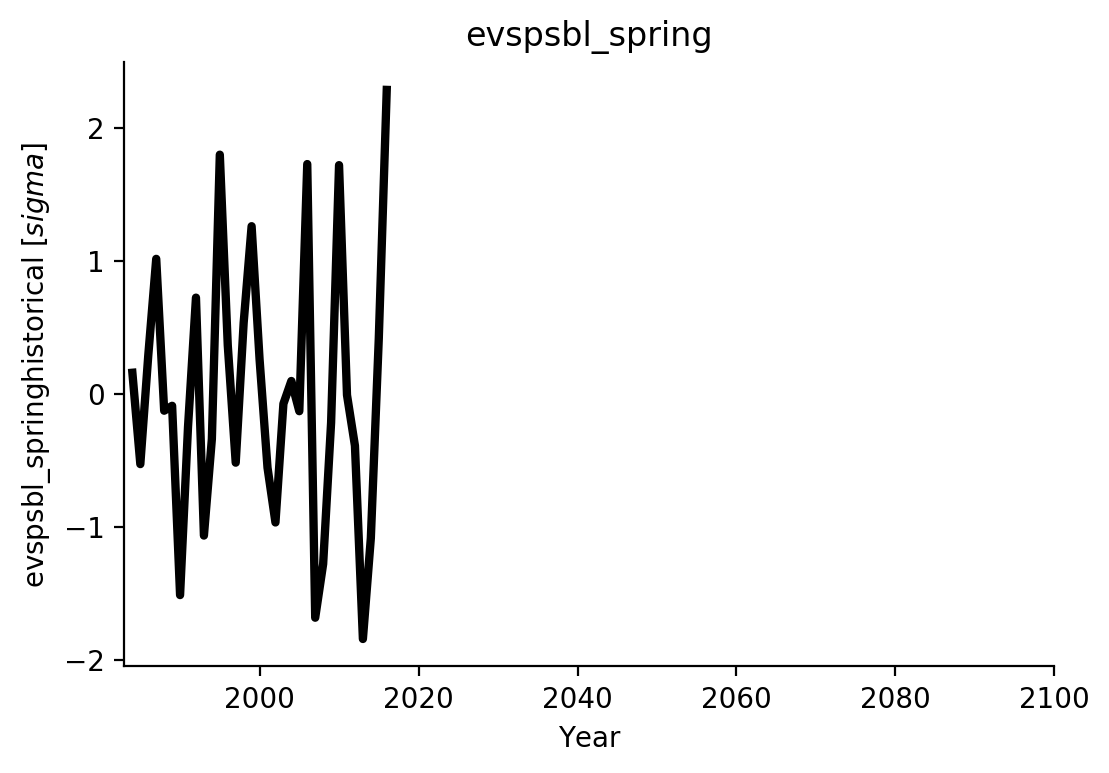

/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sbrey/anaconda3/lib/python3.6/sit

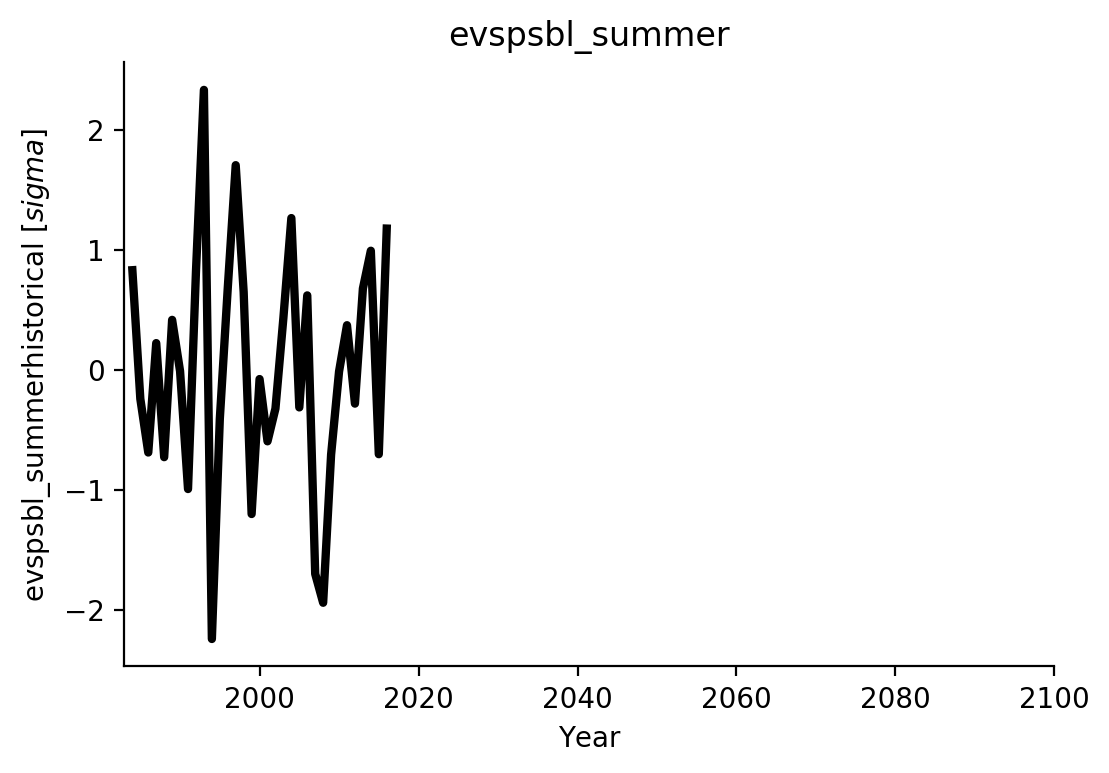

In [99]:
for f in Z_dict['Marine Regime Mountains'].keys() :
    plot_history_future(Z_dict['Marine Regime Mountains'], # Assosiated with era-interim
                        Z_lasso_all_cmip_85_dict['Marine Regime Mountains'], 
                        f)

# Use the standardized CMIP output to make predictions using the trained linear classifier

#### Here is a reminder of the operations done to the burn area target before fitting
````Python 
y_original = y_seanonal_df.loc[:, div].copy()
y_original.loc[y_original==0] = 1.
y_log = np.log10(y_original.values)
y_log_detrend = signal.detrend(y_log)
y = y_log_detrend.copy()
````



In [100]:
era_years = years

In [101]:
def make_BA_dictionary(regression_name, rcp, Z_dict, div_lasso_list, make_plots=True) : 
    """
    Doc string required. 
    """
    print("working on burn area projections using %s" % regression_name)
    
    
    # Create a directory to save burn area predictions 
    if make_plots :
        BA_save_dir = os.path.join(save_dir_base, "BA_projections")
        if not os.path.isdir(BA_save_dir) : 
            os.mkdir(BA_save_dir)
            
    # A dictionary of dataframes where each dataframes columns are
    # burn area projections for a single CMIP5 model 
    BA_dict = {}        
            
    # Only loop through divs that have data
    divs_with_fits = []
    for div in Z_dict.keys() : 
        if len(Z_dict[div].keys()) > 0 :
            divs_with_fits.append(div)
    #print(divs_with_fits)
        
    # Work on a division at a time
    for div in divs_with_fits : 
        
        #print(div)
    
        # Get the lasso regression model associated with this regression
        # and this division 
        lasso_lm = div_lasso_list[div][regression_name]

        # Get the dimensions of the burn area data to save 
        models_for_div = list(Z_dict[div].keys())
        z_years = Z_dict[div][models_for_div[0]].index.values.copy()
        
        # Create dataframe to store predictions [year X model]
        BA_df = pd.DataFrame(np.nan, columns=models_for_div, index = z_years)

        # I have confirmed z columns align with coeficients 
        for m in models_for_div : 

            # Get the features for a given division & model 
            z_pred = Z_dict[div][m].copy()
            
            # Subset predictors to columns used for lasso_plant & lasso_atmos
            if regression_name == "lasso_atmos" : 
                z_pred = z_pred.loc[:, Z_atmos.columns.values]
            elif regression_name == "lasso_plant" : 
                z_pred = z_pred.loc[:, Z_plant.columns.values]
            # All columns needed if lasso_all 
            
            z_column_names = z_pred.columns.values.copy()
            # nans need to be replaced with zeros to be used in 
            # .predict method. 
            z_predictors = z_pred.fillna(value=0)    

            # Get the mean value of the log10 transformed target
            # because the mean was taken away. This will be added
            # to projected burn areas that start at 0 by design 
            y_bar = np.mean(div_ylog10[div])

            # Lasso target
            lasso_target = div_lasso_targets[div]+y_bar

            # make projection and get linear fit 
            y_predicted = lasso_lm.predict(z_predictors.values) + y_bar
            lm = stats.linregress(z_years, y_predicted)
            predicted_fit = lm.slope*z_years + lm.intercept

            # Save the burn area predicted by regression type driven my CMIP5 output
            BA_df.loc[:, m] = y_predicted

            if make_plots : 

                file_name = div.replace("/", " ") + "_" + m + "_"+ regression_name + "_rcp"+ rcp + "_burn_area.png"
                f = os.path.join(BA_save_dir, file_name)

                plt.figure(dpi=200, figsize=(6,3))
                plt.plot(z_years, y_predicted, label="predicted")
                plt.plot(z_years, predicted_fit, label="predicted regression")
                plt.plot(era_years, lasso_target, label="original target")
                plt.axhline(y=y_bar, color="k", linestyle="--", label="target mean")

                plt.legend()
                plt.title(div + " BA using "+ m)
                plt.ylabel("log$_{10}$(burn area [acres])")
                plt.savefig(f)
                plt.close()
            
            BA_dict[div] = BA_df
            
    # Save the dictionary to disk
    f_dict = regression_name + "_BA_rcp" + rcp + ".obj"
    with open(os.path.join(save_dir_base, f_dict), 'wb') as fp:
        pickle.dump(BA_dict, fp)
    
    return BA_dict   

### Make burn area predictions and write them to disk. 

In [102]:
BA_atmos_85 = make_BA_dictionary("lasso_atmos", "85", Z_lasso_atmos_cmip_85_dict, div_lasso_list, make_plots=True)
BA_atmos_45 = make_BA_dictionary("lasso_atmos", "45", Z_lasso_atmos_cmip_45_dict, div_lasso_list, make_plots=True)

BA_plant_85 = make_BA_dictionary("lasso_plant", "85", Z_lasso_plant_cmip_85_dict, div_lasso_list, make_plots=True)
BA_plant_45 = make_BA_dictionary("lasso_plant", "45", Z_lasso_plant_cmip_45_dict, div_lasso_list, make_plots=True)

BA_all_85 = make_BA_dictionary("lasso_all", "85", Z_lasso_all_cmip_85_dict, div_lasso_list, make_plots=True)
BA_all_45 = make_BA_dictionary("lasso_all", "45", Z_lasso_all_cmip_45_dict, div_lasso_list, make_plots=True)

working on burn area projections using lasso_atmos
working on burn area projections using lasso_atmos
working on burn area projections using lasso_plant
working on burn area projections using lasso_plant
working on burn area projections using lasso_all
working on burn area projections using lasso_all


Sorry trees, snow, etc. At least the Baby Boomers will get to retire? 